<a href="https://colab.research.google.com/github/MaryamNourii/HeartData-Analysis/blob/main/HeartData_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dask[dataframe]
!pip install --upgrade scikit-learn

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    make_scorer,
    confusion_matrix
)
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold, cross_val_predict


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load dataset


In [ ]:
def read_dataset(file_path):
  data = pd.read_csv(file_path)
  return data

# Functions for CRISP-DM data cleaning and analysis


========================================
Step: Analyzing Initial Data
========================================

In [ ]:
def analyze_data(df, stage,categorical_cols,numerical_cols):

    """
    Analyze data statistics at different stages of cleaning.
    """
    stats = {
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Missing Values": df.isnull().sum().sum(),
        "Duplicate Rows": df.duplicated().sum(),
        # "Numerical Features": df.select_dtypes(include=["float64", "int64"]).columns.tolist(),
        # "Categorical Features": df.select_dtypes(include=["object", "category"]).columns.tolist(),
         "Categorical Features": categorical_cols,
         "Numerical Features": numerical_cols
    }
    print(f"\nData Analysis - {stage}")
    for key, value in stats.items():
        print(f"{key}: {value}")
    return stats


def detect_categorical_columns(df, threshold=10):
  """
  Detecting categorical columns.
  """
  categorical_cols = []
  for col in df.columns:
    unique_values = df[col].nunique()
    if unique_values <= threshold:
      categorical_cols.append(col)
  return categorical_cols


def compare_stats(before_stats, after_stats):
    """
    Compare statistics before and after cleaning.
    """
    print("\nComparison of Data Statistics Before and After Cleaning:")
    comparison = {
        "Metric": ["Rows", "Columns", "Missing Values", "Duplicate Rows"],
        "Before Cleaning": [
            before_stats["Rows"],
            before_stats["Columns"],
            before_stats["Missing Values"],
            before_stats["Duplicate Rows"],
        ],
        "After Cleaning": [
            after_stats["Rows"],
            after_stats["Columns"],
            after_stats["Missing Values"],
            after_stats["Duplicate Rows"],
        ],
    }
    comparison_df = pd.DataFrame(comparison)
    print(comparison_df)

    # Visualize the comparison
    comparison_df.set_index("Metric")[["Before Cleaning", "After Cleaning"]].plot(
        kind="bar", figsize=(10, 6), color=["skyblue", "salmon"]
    )
    plt.title("Comparison of Data Statistics Before and After Cleaning")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

def analyze_field_statistics(df, Categorical_cols):
    """
    Perform statistical analysis and visualization for each field in the dataset.
    """
    print("\nStep: Statistical Analysis and Visualization of Fields")

    for column in df.columns:
        print("=" * 40)
        print(f"Analyzing Field: {column}")
        print("=" * 40)

        # Check if the column is numerical or categorical
        if column in Categorical_cols:
            print("Categorical Field")
            # Calculate frequency of values
            value_counts = df[column].value_counts()
            print(value_counts)
            # Plot Barplot
            plt.figure(figsize=(8, 6))
            sns.countplot(x=df[column], palette="pastel", order=value_counts.index, hue=df[column], legend=False)
            plt.title(f"Barplot of {column}")
            plt.ylabel("Count")
            plt.xlabel("Category")
            plt.xticks(rotation=45)
            plt.show()
        else:
            print("Numerical Field")
            # Calculate statistics
            stats = df[column].describe()
            print(stats)

            # Plot Histogram and Boxplot
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.histplot(df[column], kde=True, ax=axes[0], color="skyblue")
            axes[0].set_title(f"Histogram of {column}")
            sns.boxplot(x=df[column], ax=axes[1], color="orange")
            axes[1].set_title(f"Boxplot of {column}")
            plt.tight_layout()
            plt.show()


def plot_correlation_matrix(data):
    """
    Calculating the correlation matrix and drawing the heatmap
    """
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()


========================================
Step: Exploring and Handling Missing Values
========================================

In [ ]:
def explore_missing_values(df):
    """
    Detect and visualize missing values in the dataset.
    """
    print("\nStep: Detecting Missing Values")
    print("Missing Values per Column:")
    missing = df.isnull().sum()[df.isnull().sum() > 0]
    if missing.empty:
        print("No missing values detected.")
    else:
        print(missing)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
    plt.title("Heatmap of Missing Values")
    plt.show()

def handle_missing_values(df,Categorical_cols):
    """
    Handle missing values by filling with median for numerical features
    and mode for  features. Prevent further missing values.

    Return Dataset without missing value.
    """
    print("\nStep: Handling Missing Values")

    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col in Categorical_cols:#df[col].dtype in ["float64", "int64"]:
                print(f"Filling missing values in {col} with mode.")
                df[col]=df[col].fillna(df[col].mode()[0])
            else:
                print(f"Filling missing values in {col} with median.")
                df[col]=df[col].fillna(df[col].median())
    print("Missing values handled.")
    return df

========================================
Step: Detecting and Removing Duplicates
========================================


In [ ]:
def detect_duplicates(df):
    """
    Detect duplicate rows in the dataset.
    """
    print("\nStep: Detecting Duplicate Rows")
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicates}")
    return duplicates

def remove_duplicates(df):
    """
    Remove duplicate rows from the dataset.
    """
    print("\nStep: Removing Duplicate Rows")
    initial_count = df.shape[0]
    df.drop_duplicates(inplace=True)
    print(f"Removed {initial_count - df.shape[0]} duplicate rows.")
    print(f"Rows remaining: {df.shape[0]}")
    return df

========================================
Step: Detecting Noise in Categorical Features
========================================

In [ ]:
def detect_noise(df,_cols):
    """
    Detect potential noise in features.
    """
    print("\nStep: Detecting Noise in Features")
    for col in _cols:
        print(f"\nUnique values in {col}:")
        print(df[col].value_counts())
    print("Noise detection completed.")

========================================
Step: Detecting and Removing Outliers
========================================

In [ ]:
def detect_distribution(df, column):
    """
    Detect the distribution of a numerical column using statistical tests.
    Returns: 'Normal' or 'Non-Normal'
    """
    print(f"\nAnalyzing Distribution for: {column}")

    # Perform Shapiro-Wilk test for normality
    stat, p_value = shapiro(df[column].dropna())
    print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p_value:.4f}")

    if p_value > 0.05:
        print(f"The distribution of {column} appears to be Normal.")
        return 'Normal'
    else:
        print(f"The distribution of {column} appears to be Non-Normal.")
        return 'Non-Normal'

def detect_and_handle_outliers(df,categorical_cols):
    """
    Detect and manage outliers for numerical and categorical features.
    """
    print("\nStep: Detecting and Handling Outliers")

    for column in df.columns:
        print(f"\nAnalyzing Column: {column}")

        if column in categorical_cols:
            # Categorical Feature
            print("Type: Categorical")
            value_counts = df[column].value_counts()
            print(f"Value Counts:\n{value_counts}")

            # Identify Rare Categories
            rare_categories = value_counts[value_counts < 0.05 * len(df)].index
            print(f"Rare Categories: {list(rare_categories)}")


            # Handle Rare Categories
            if len(rare_categories) > 0:
                print("Handling Rare Categories by Combining into 'Other'")
                df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)

            # Visualization
            plt.figure(figsize=(12, 6))
            sns.countplot(x=df[column], palette="pastel", order=df[column].value_counts().index, hue=df[column], legend=False)
            plt.title(f"Barplot After Handling Rare Categories for {column}")
            plt.xticks(rotation=45)
            plt.show()

        else:
            # Numerical Feature
            print("Type: Numerical")

            # Check Distribution using Shapiro-Wilk test
            distribution = detect_distribution(df, column)

            if distribution == 'Normal':  # Normal Distribution
                print("Using Z-Score to Detect Outliers...")
                z_scores = (df[column] - df[column].mean()) / df[column].std()
                outliers = df[abs(z_scores) > 3]
            else:  # Non-Normal Distribution
                print("Using IQR to Detect Outliers...")
                Q1 = df[column].quantile(0.25)
                Q3 = df[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

            print(f"Number of Outliers Detected: {len(outliers)}")

            # Handle Outliers
            if len(outliers) > 0:
                print("Handling Outliers by Clipping...")
                df[column] = df[column].clip(lower=df[column].quantile(0.05), upper=df[column].quantile(0.95))

            # Visualization
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=df[column], color="orange")
            plt.title(f"Boxplot After Handling Outliers for {column}")
            plt.show()

    return df

#Save cleaned dataset

In [ ]:
def save_data(cleaned_data,file_path):
  """
  Save new dateset After cleaning.
  """
  cleaned_data.to_csv(file_path,index=False)
  print("\n Cleaned dataset saved.")

# Main function to execute the CRISP-DM cleaning process




In [ ]:
def crisp_data_cleaning(df, file_path):
    """
    Execute the CRISP-DM data cleaning process while ensuring no new missing values are introduced.
    Return Cleaned Dataset.
    """

    print("=" * 40)
    print("Step: Analyzing Initial Data")
    print("=" * 40)
    categorical_cols = detect_categorical_columns(data)
    numerical_cols = list(set(data.columns.tolist()) - set(categorical_cols))
    initial_data_stats = analyze_data(df, "Before Cleaning",categorical_cols,numerical_cols)


    print("=" * 40)
    print("Step: Calculating the correlation matrix and drawing the heatmap.")
    print("=" * 40)
    plot_correlation_matrix(df)


    print("\n" + "=" * 40)
    print("Step: Statistical Analysis Before Cleaning")
    print("=" * 40)
    analyze_field_statistics(df,categorical_cols)

    print("\n" + "=" * 40)
    print("Step: Exploring and Handling Missing Values")
    print("=" * 40)
    explore_missing_values(df)
    df = handle_missing_values(df,categorical_cols)

    print("\n" + "=" * 40)
    print("Step: Detecting and Removing Duplicates")
    print("=" * 40)
    if detect_duplicates(df) > 0:
       df = remove_duplicates(df)

    print("\n" + "=" * 40)
    print("Step: Detecting and Removing Noise in Categorical Features")
    print("=" * 40)
    detect_noise(df,categorical_cols)

    print("\n" + "=" * 40)
    print("Step: Detecting and Removing Outliers")
    print("=" * 40)
    df = detect_and_handle_outliers(df,categorical_cols)

    print("\n" + "=" * 40)
    print("Step: Statistical Analysis After Cleaning")
    print("=" * 40)
    analyze_field_statistics(df,categorical_cols)

    print("\n" + "=" * 40)
    print("Step: Analyzing Data After Cleaning")
    print("=" * 40)
    cleaned_data_stats = analyze_data(df, "After Cleaning",categorical_cols,numerical_cols)
    compare_stats(initial_data_stats, cleaned_data_stats)

    print("\n" + "=" * 40)
    print("Step: Save new dataset After Cleaning")
    print("=" * 40)
    save_data(df, file_path)



#CRISP-DM Data preparation process

========================================
Step: Splitting Data
========================================

In [ ]:
def split_train_test(df, target_column, test_size=0.2, random_state=42):
    """
    Split the dataset into training and testing sets and handle imbalance in the training set.
    """
    print("\nStep: Splitting Data into Training and Testing Sets")

    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test


========================================
Step: Handling Imbalance
========================================

In [ ]:
def handle_imbalance(X, y):
    """
    Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique).
    """
    print("\nStep: Managing Class Imbalance in the Dataset")
    print("Class Distribution Before SMOTE:")
    print(y.value_counts(normalize=True) * 100)

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    print("\nClass Distribution After SMOTE:")
    print(pd.Series(y_resampled).value_counts(normalize=True) * 100)

    # Visualize the new distribution
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y_resampled, palette="pastel")
    plt.title("Class Distribution After SMOTE")
    plt.ylabel("Count")
    plt.xlabel("Class")
    plt.show()

    return X_resampled, y_resampled

def detect_handle_imbalance(X_train, y_train, threshold=0.2):

    # Check for imbalance in training set and handle it
    if y_train.value_counts(normalize=True).min() < threshold:
        print("\nDetected Class Imbalance in Training Set")
        X_train, y_train = handle_imbalance(X_train, y_train)
    else:
        print("\nNo significant class imbalance detected.")
    return X_train, y_train

#Data Transfer

In [ ]:
def data_transfer(X_train, X_test, numerical_cols, categorical_cols):
  """
  Numerical columns are standardized and categorical columns are encoded.
  Apply preprocessing:
    Using fit_transform on the training data.
    Using transform on test data.

  Return X_train, X_test processed.
  """
  #Apply standardization on numeric columns
  # scaler = StandardScaler()
  # X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
  # X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

  #Apply MinMAxScalar on numeric columns
  scaler = MinMaxScaler()
  X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
  X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


  # Apply Label Encoding on categorized columns
  label_encoders = {}
  for col in categorical_cols:
      le = LabelEncoder()
      X_train[col] = le.fit_transform(X_train[col])
      X_test[col] = le.transform(X_test[col])
      label_encoders[col] = le  # Save the LabelEncoder for possible future use

  print("\nTransformed  X_train, X_test.")
  return X_train, X_test

# Main function to execute the CRISP-DM preparation process

In [ ]:
def crisp_data_preparing(df):
    """
    Execute the CRISP-DM data preparing process while ensuring Data cleand.
    """
    print("=" * 40)
    print("Step: Detecting categorical and numerical columns.")
    print("=" * 40)
    target_column = 'c'
    categorical_cols = detect_categorical_columns(df)
    numerical_cols = list(set(df.columns.tolist()) - set(categorical_cols))
    categorical_cols = categorical_cols[:-1]

    print("\n" + "=" * 40)
    print("Step: Splitting Data.")
    print("=" * 40)
    X_train, X_test, y_train, y_test = split_train_test(df, target_column)

    print("\n" + "=" * 40)
    print("Step: Handling Imbalance.")
    print("=" * 40)
    X_train, y_train = detect_handle_imbalance(X_train, y_train, 0.2)

    print("\n" + "=" * 40)
    print("Step: Transforming X_train, X_test.")
    print("=" * 40)
    X_train_processed, X_test_processed = data_transfer(X_train, X_test, numerical_cols, categorical_cols)


    print("\n" + "=" * 40)
    print("Step: X_train , X_test , y_train, y_test are Prepared for modeling.")
    print("=" * 40)

    print("\nThe training data is processed:")
    print(X_train_processed.head())

    print("\nThe training data is processed:")
    print(X_test_processed.head())

    # Save processed data.
    X_train_processed.to_csv("X_train_processed.csv", index=False)
    X_test_processed.to_csv("X_test_processed.csv", index=False)

    return X_train_processed, X_test_processed, y_train, y_test

#CRISP-DM Modeling process

#Evaluating model performance

In [ ]:
def evaluate_model(y_test, y_pred, y_prob, model_name):
    """
    Evaluating model performance.
    """
    print(f"Evaluating {model_name}...")

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    cr = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(cr)

    return accuracy, precision, recall, f1, auc

# Function to plot the ROC curve
def plot_roc_curve(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, y_prob):.4f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

# Main function to execute the CRISP-DM modeling process

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    """
    Train and evaluate models.
    """
    results = []

    # List of models to train
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=100, random_state=42, solver='sgd'),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Support Vector Machine": SVC(probability=True, random_state=42)
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name} model...")

        # Fit on full training data and evaluate on test data
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]

        results.append(evaluate_model(y_test, y_test_pred, y_test_prob, model_name))

        print(f"{model_name} Test Accuracy:", accuracy_score(y_test, y_test_pred))
        plot_roc_curve(y_test, y_test_prob, model_name)

    # Finalize ROC Curve plot
    plt.show()

    # Return results
    return results



Optimizing models

In [ ]:
def optimize_models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate models.
    """
    results = []

    # List of models to train
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=100, random_state=42, solver='sgd'),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Support Vector Machine": SVC(probability=True, random_state=42)
    }

    model_params = {
        "Logistic Regression": {"C": [0.1, 1, 10], "solver": ["liblinear", "lbfgs"]},
        "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]},
        "XGBoost": {"n_estimators": [50, 100, 200],"learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]},
        "Neural Network": {"hidden_layer_sizes": [(50,), (100,), (100, 50)], 'activation': ['relu', 'tanh'], "learning_rate_init": [0.001, 0.01], "max_iter":[500, 1000], "solver":['adam', 'lbfgs', 'sgd']},
        "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"]},
        "Decision Tree": {"max_depth": [None, 10, 20], "criterion": ["gini", "entropy"]},
        "Support Vector Machine": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name} model...")
        # Fit on full training data and evaluate on test data
        gs_model = GridSearchCV(model, model_params[model_name], cv=5, scoring='accuracy')
        gs_model.fit(X_train, y_train)
        best_model = gs_model.best_estimator_
        print(f"Best Parameters for {model_name}:", gs_model.best_params_)
        y_test_pred = gs_model.predict(X_test)
        y_test_prob = gs_model.predict_proba(X_test)[:, 1]
        results.append(evaluate_model(y_test, y_test_pred, y_test_prob, "Optimized"+model_name))

        print(f"{model_name} Test Accuracy:", accuracy_score(y_test, y_test_pred))
        plot_roc_curve(y_test, y_test_prob, model_name)

    # Finalize ROC Curve plot
    plt.show()

    # Return results
    return results

Cross-validation and Evaluate models

In [ ]:
def train_and_cross_validate(X_train, X_test, y_train, y_test):
    """
    Train and evaluate models with Cross-Validation and Test Data Evaluation
    """
    results = []

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # List of models to train
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": xgb.XGBClassifier(n_estimators=100, random_state=42),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=100, random_state=42, solver='sgd'),
        "K-Nearest Neighbors": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Support Vector Machine": SVC(probability=True, random_state=42)
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name} model...")

        # Cross-validation on training data
        pred = cross_val_predict(model, X_train, y_train, cv=cv)
        prob = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

        # Evaluate on training data
        results.append(evaluate_model(y_train, pred, prob, model_name))
        print(f"{model_name} Train Accuracy:", accuracy_score(y_train, pred))
        # plot_roc_curve(y_train, prob, model_name)

        # Fit on full training data and evaluate on test data
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]

        print(f"{model_name} Test Accuracy:", accuracy_score(y_test, y_test_pred))
        plot_roc_curve(y_test, y_test_prob, model_name)


    # Finalize ROC Curve plot
    plt.show()

    # Return results
    return results

In [ ]:
def train_and_cross_validate_AfterOpt(X_train, X_test, y_train, y_test):
    """
    Train and evaluate models with Cross-Validation and Test Data Evaluation
    """
    results = []

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # List of models to train
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, C= 0.1, solver= 'liblinear'),
        "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42, max_depth= None),
        "XGBoost": xgb.XGBClassifier(n_estimators=50, random_state=42,learning_rate= 0.1, max_depth= 3),
        "Neural Network": MLPClassifier(activation= 'relu', hidden_layer_sizes= (100,), learning_rate_init= 0.001, max_iter= 500, solver= 'sgd', random_state=42),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors= 5, weights= 'distance'),
        "Decision Tree": DecisionTreeClassifier(criterion= 'gini', max_depth= 10, random_state=42),
        "Support Vector Machine": SVC(probability=True, C= 0.1, kernel= 'rbf', random_state=42)
    }

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name} model...")

        # Cross-validation on training data
        pred = cross_val_predict(model, X_train, y_train, cv=cv)
        prob = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

        # Evaluate on training data
        results.append(evaluate_model(y_train, pred, prob, model_name))
        print(f"{model_name} Train Accuracy:", accuracy_score(y_train, pred))
        # plot_roc_curve(y_train, prob, model_name)

        # Fit on full training data and evaluate on test data
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        y_test_prob = model.predict_proba(X_test)[:, 1]

        print(f"{model_name} Test Accuracy:", accuracy_score(y_test, y_test_pred))
        plot_roc_curve(y_test, y_test_prob, model_name)


    # Finalize ROC Curve plot
    plt.show()

    # Return results
    return results

# Display summary of results

In [ ]:
def Display_results(results):
  """
  Display summary of results.
  """
  models = ["Logistic Regression", "Random Forest", "XGBoost", "Neural Network", "K-Nearest Neighbors (KNN)", "Decision Tree", "Support Vector Machine (SVM)"]
  metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]
  result_df = pd.DataFrame(results, columns=metrics, index=models)
  print("\nSummary of Results:")
  print(result_df)

# Execute CRISP-DM process




Execute CRISP-DM Cleaning process

Step: Analyzing Initial Data

Data Analysis - Before Cleaning
Rows: 597
Columns: 14
Missing Values: 787
Duplicate Rows: 1
Categorical Features: ['sex', 'chest pain', 'blood sugar', 'electrocardiographic ', 'exercise induced', 'slope', 'ca', 'thal', 'c']
Numerical Features: ['cholestoral ', 'blood pressure', 'heart rate', 'depression ', 'Age (age in year)']
Step: Calculating the correlation matrix and drawing the heatmap.


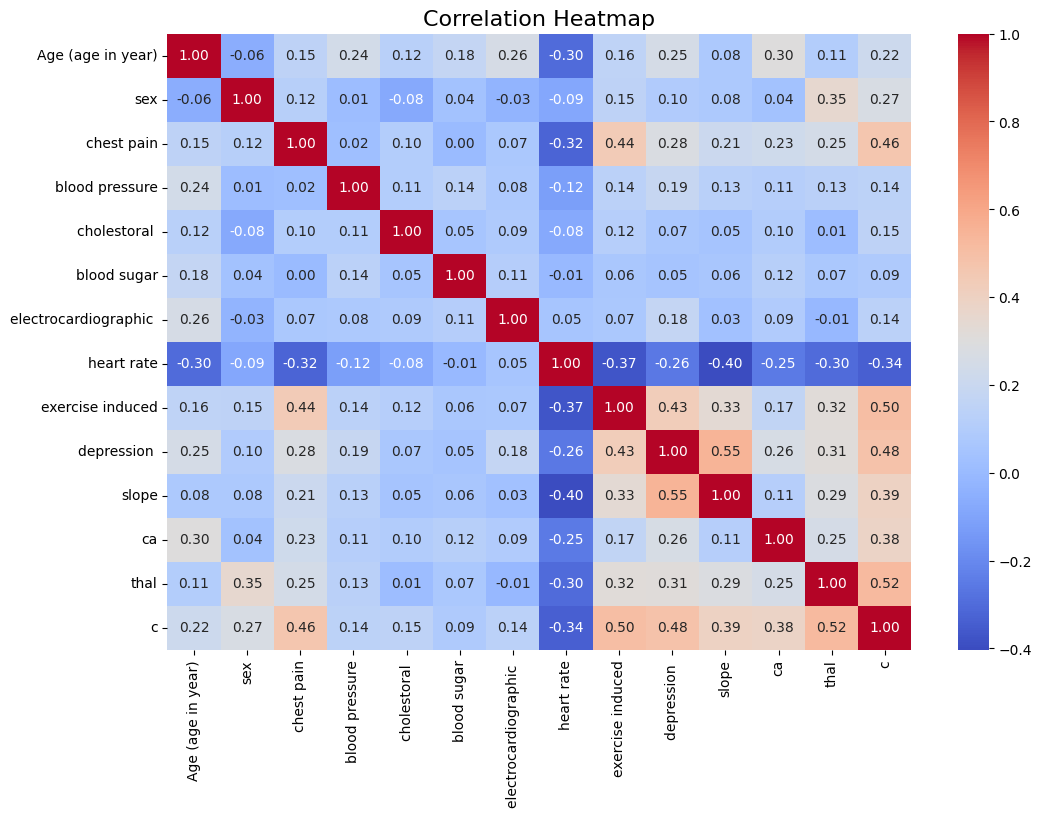


Step: Statistical Analysis Before Cleaning

Step: Statistical Analysis and Visualization of Fields
Analyzing Field: Age (age in year)
Numerical Field
count    597.000000
mean      51.182580
std        9.074366
min       28.000000
25%       44.000000
50%       52.000000
75%       58.000000
max       77.000000
Name: Age (age in year), dtype: float64


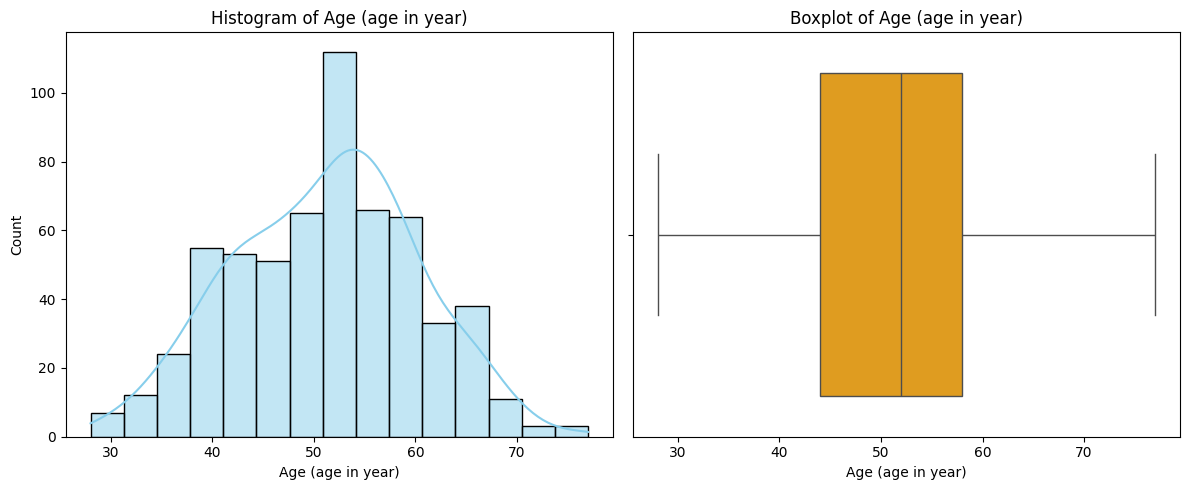

Analyzing Field: sex
Categorical Field
sex
1    419
0    178
Name: count, dtype: int64


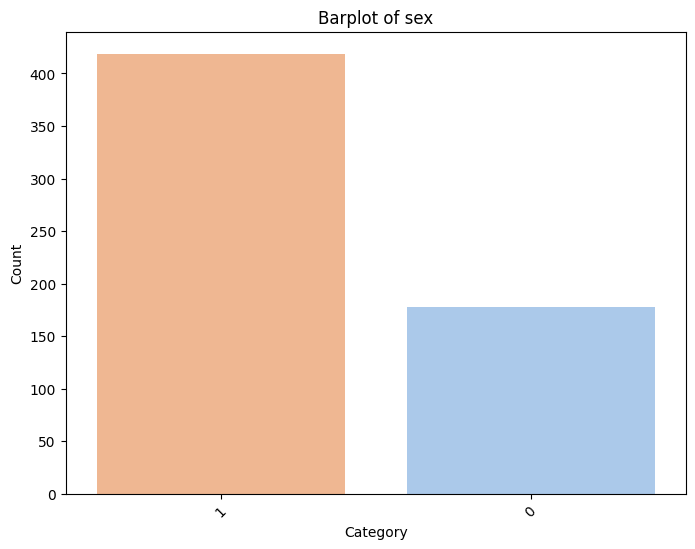

Analyzing Field: chest pain
Categorical Field
chest pain
4    267
2    156
3    140
1     34
Name: count, dtype: int64


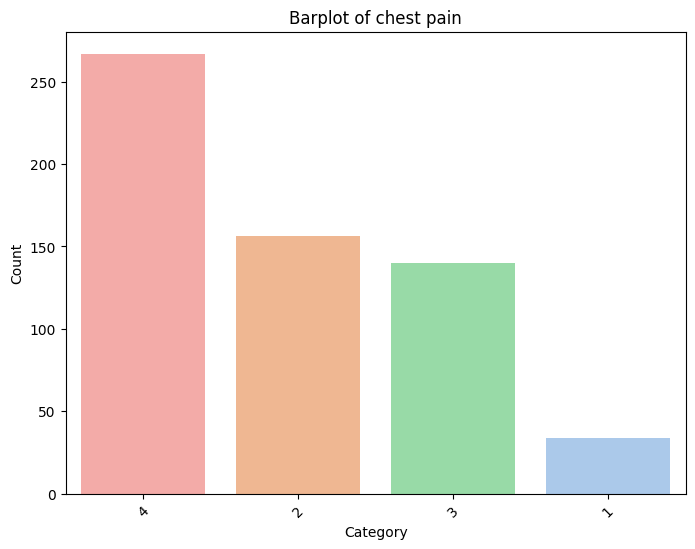

Analyzing Field: blood pressure
Numerical Field
count    596.000000
mean     132.129195
std       17.603812
min       92.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: blood pressure, dtype: float64


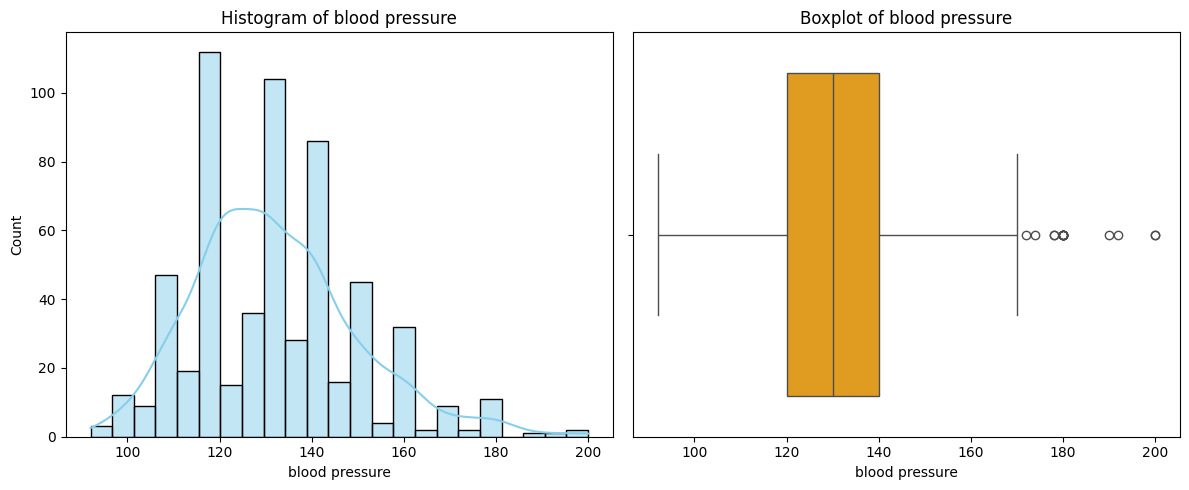

Analyzing Field: cholestoral 
Numerical Field
count    574.000000
mean     248.655052
std       59.784805
min       85.000000
25%      211.000000
50%      242.500000
75%      278.750000
max      603.000000
Name: cholestoral , dtype: float64


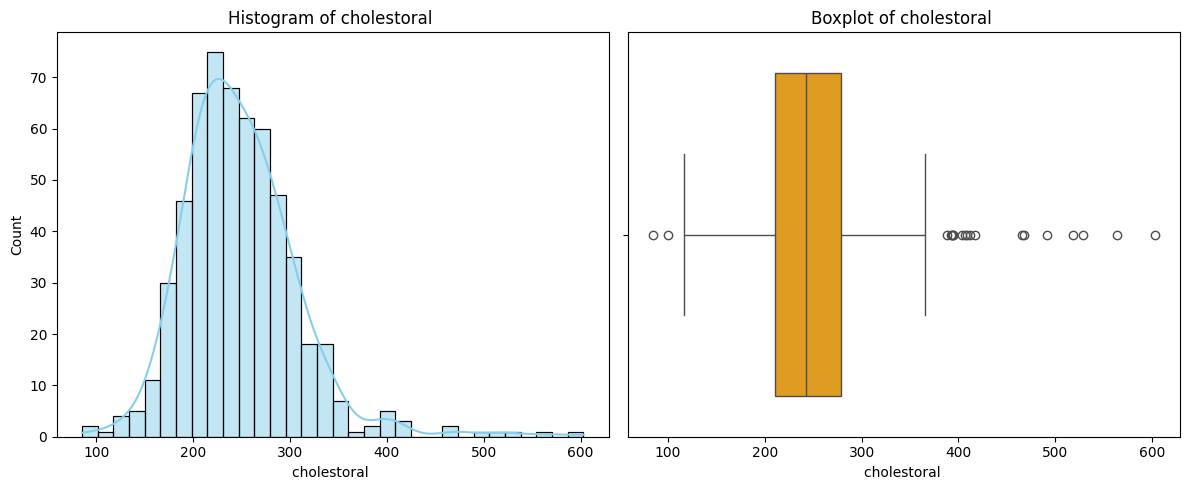

Analyzing Field: blood sugar
Categorical Field
blood sugar
0.0    524
1.0     65
Name: count, dtype: int64


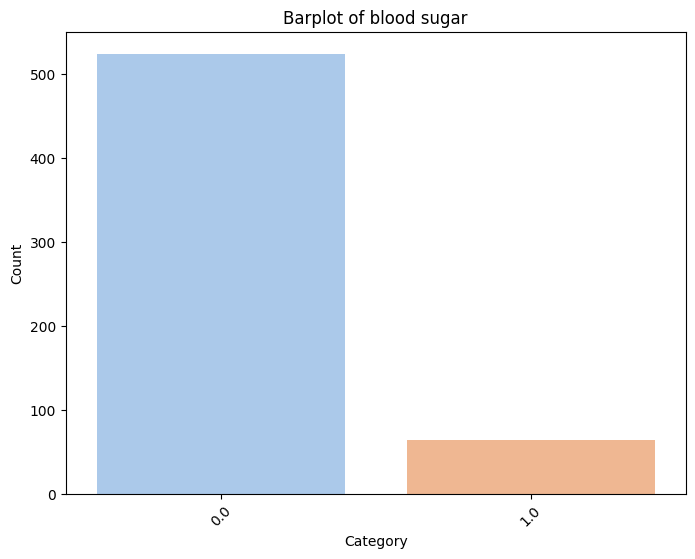

Analyzing Field: electrocardiographic 
Categorical Field
electrocardiographic 
0.0    386
2.0    154
1.0     56
Name: count, dtype: int64


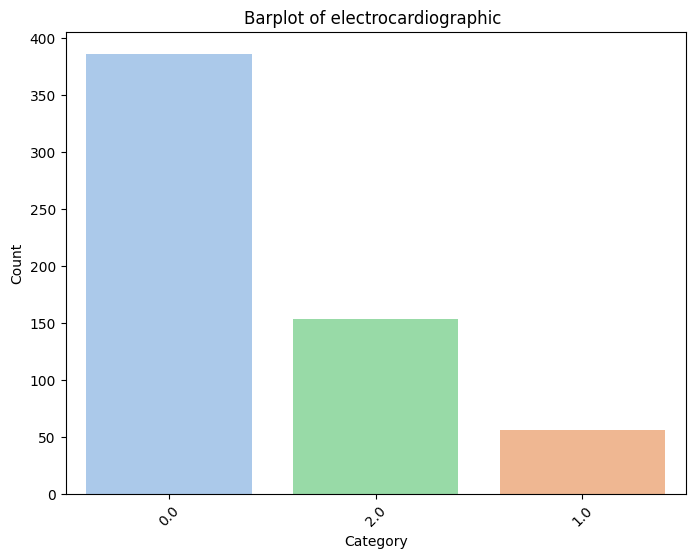

Analyzing Field: heart rate
Numerical Field
count    596.000000
mean     144.456376
std       23.794282
min       71.000000
25%      128.000000
50%      146.000000
75%      162.000000
max      202.000000
Name: heart rate, dtype: float64


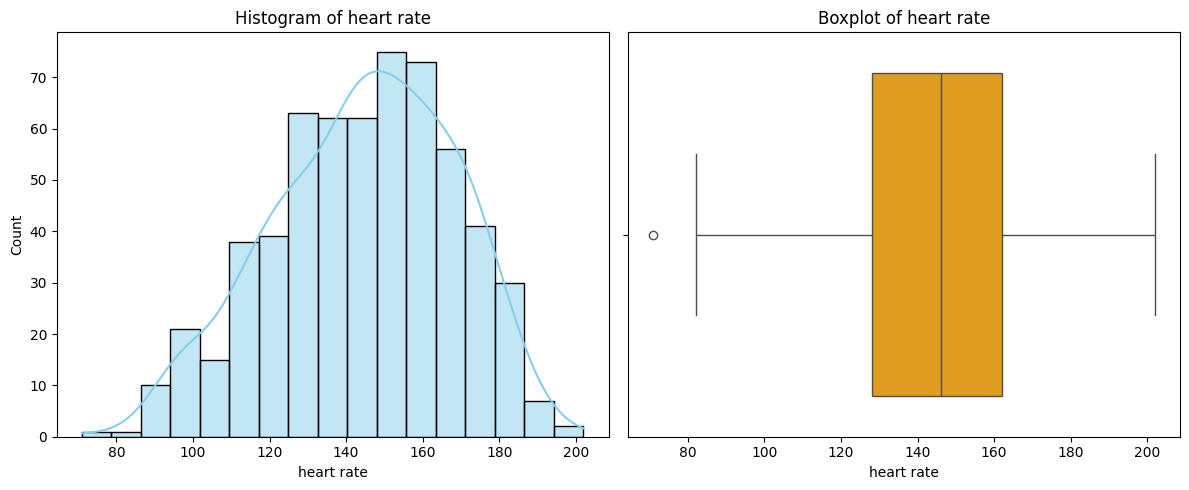

Analyzing Field: exercise induced
Categorical Field
exercise induced
0.0    408
1.0    188
Name: count, dtype: int64


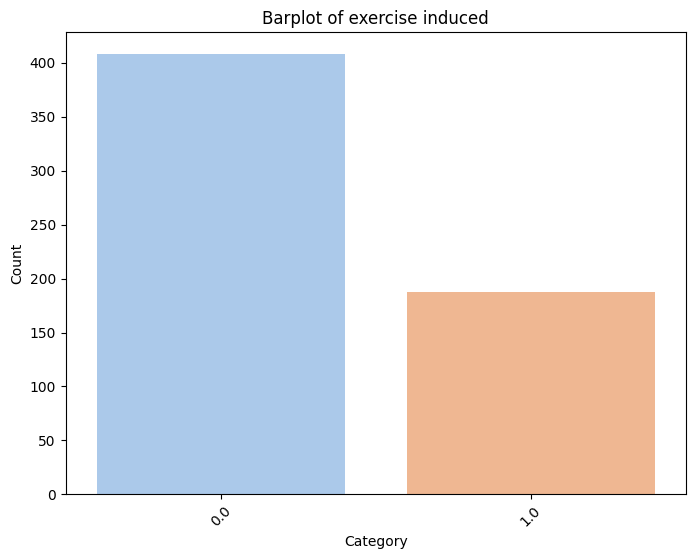

Analyzing Field: depression 
Numerical Field
count    597.000000
mean       0.816248
std        1.067938
min        0.000000
25%        0.000000
50%        0.200000
75%        1.500000
max        6.200000
Name: depression , dtype: float64


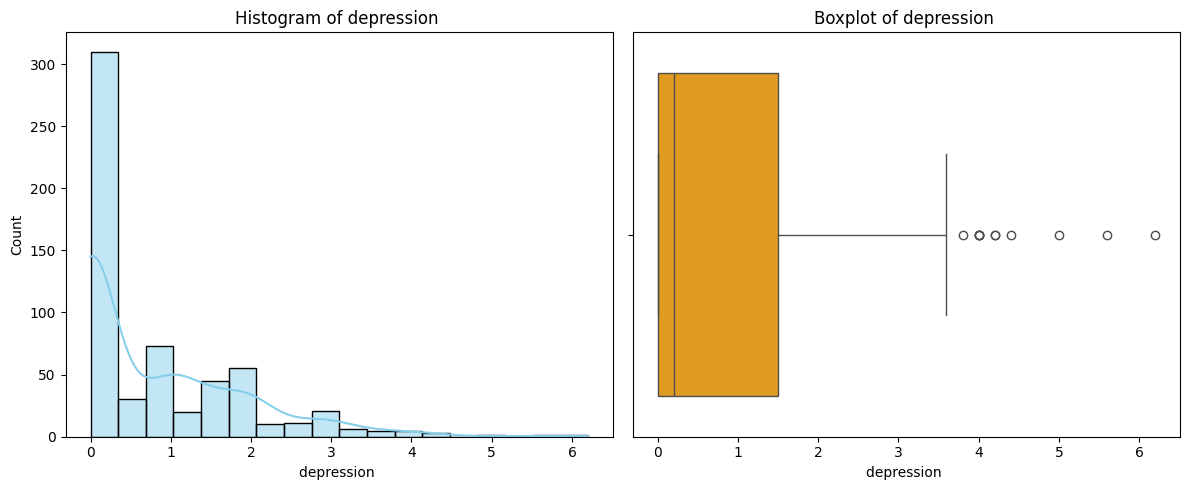

Analyzing Field: slope
Categorical Field
slope
2.0    231
1.0    154
3.0     22
Name: count, dtype: int64


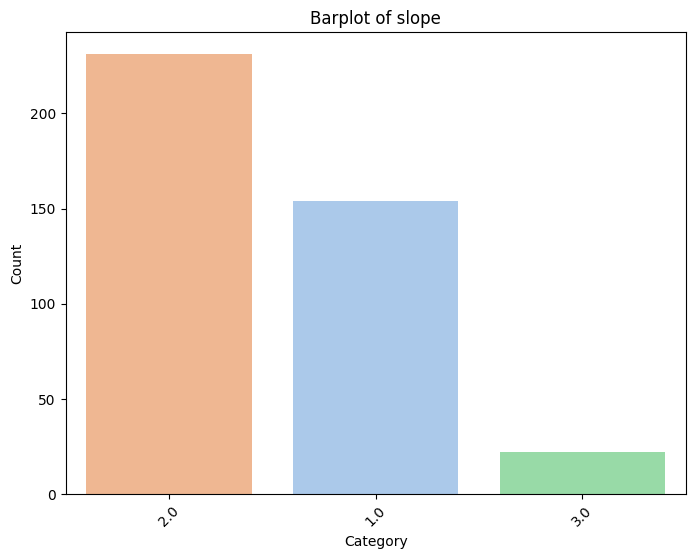

Analyzing Field: ca
Categorical Field
ca
0.0    179
1.0     65
2.0     38
3.0     20
9.0      1
Name: count, dtype: int64


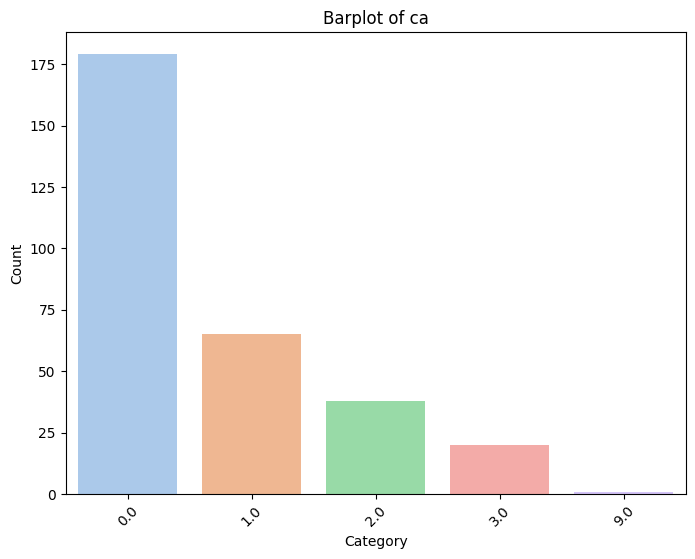

Analyzing Field: thal
Categorical Field
thal
3.0    173
7.0    128
6.0     28
Name: count, dtype: int64


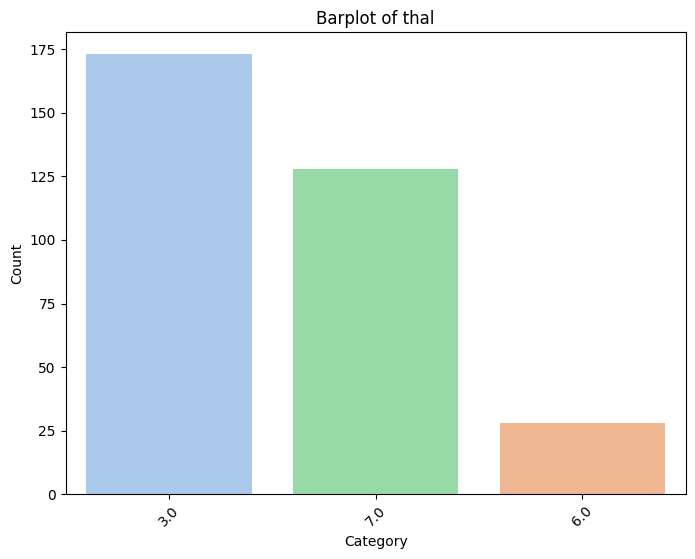

Analyzing Field: c
Categorical Field
c
0    352
1    245
Name: count, dtype: int64


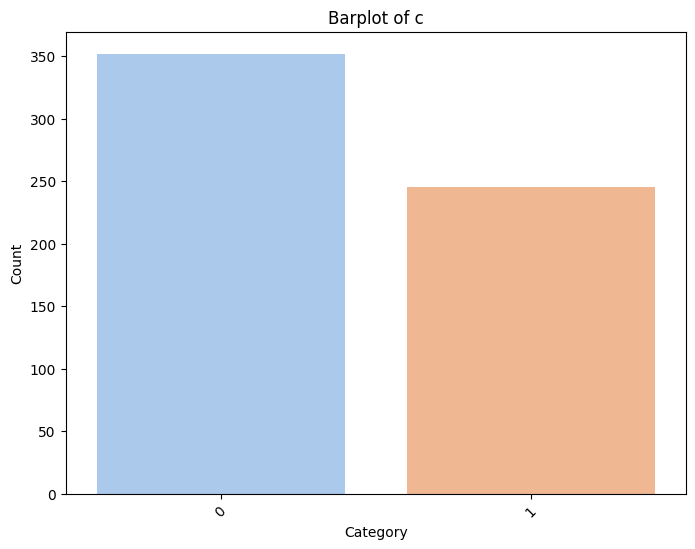


Step: Exploring and Handling Missing Values

Step: Detecting Missing Values
Missing Values per Column:
blood pressure             1
cholestoral               23
blood sugar                8
electrocardiographic       1
heart rate                 1
exercise induced           1
slope                    190
ca                       294
thal                     268
dtype: int64


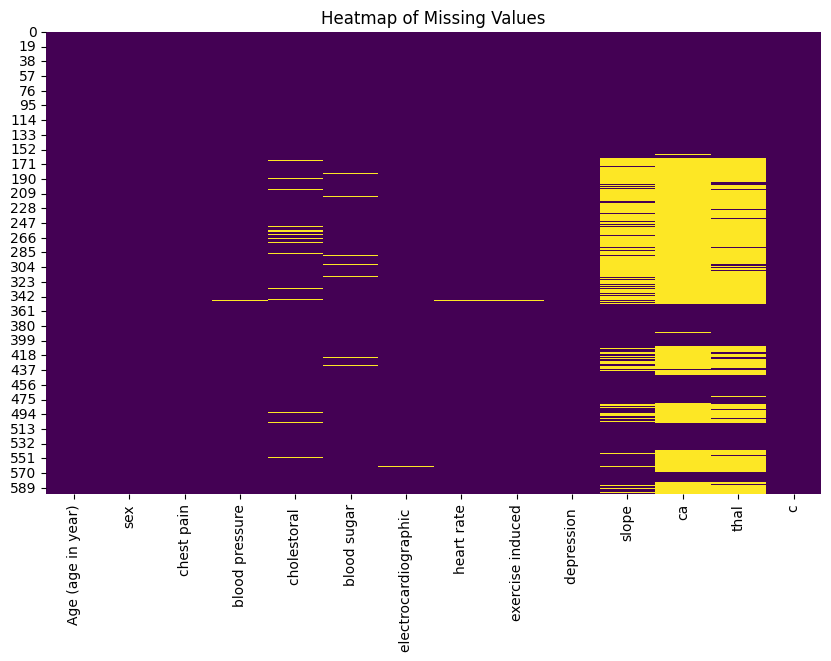


Step: Handling Missing Values
Filling missing values in blood pressure with median.
Filling missing values in cholestoral  with median.
Filling missing values in blood sugar with mode.
Filling missing values in electrocardiographic  with mode.
Filling missing values in heart rate with median.
Filling missing values in exercise induced with mode.
Filling missing values in slope with mode.
Filling missing values in ca with mode.
Filling missing values in thal with mode.
Missing values handled.

Step: Detecting and Removing Duplicates

Step: Detecting Duplicate Rows
Number of duplicate rows: 1

Step: Removing Duplicate Rows
Removed 1 duplicate rows.
Rows remaining: 596

Step: Detecting and Removing Noise in Categorical Features

Step: Detecting Noise in Features

Unique values in sex:
sex
1    419
0    177
Name: count, dtype: int64

Unique values in chest pain:
chest pain
4    267
2    155
3    140
1     34
Name: count, dtype: int64

Unique values in blood sugar:
blood sugar
0.0    531
1

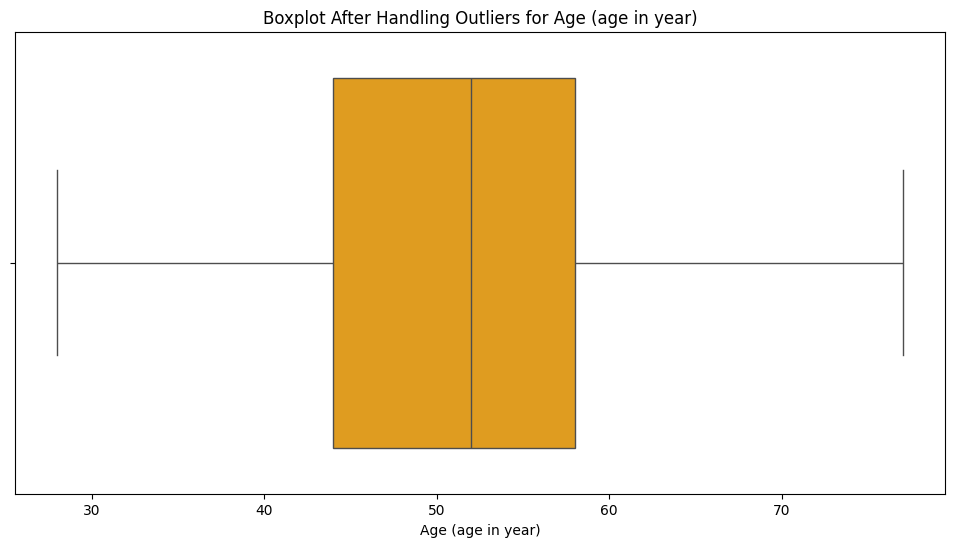


Analyzing Column: sex
Type: Categorical
Value Counts:
sex
1    419
0    177
Name: count, dtype: int64
Rare Categories: []


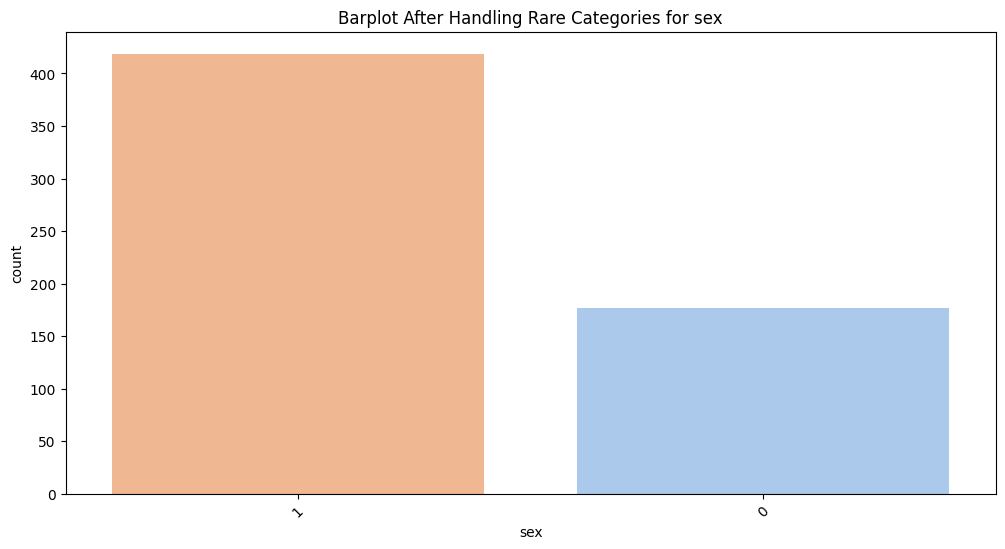


Analyzing Column: chest pain
Type: Categorical
Value Counts:
chest pain
4    267
2    155
3    140
1     34
Name: count, dtype: int64
Rare Categories: []


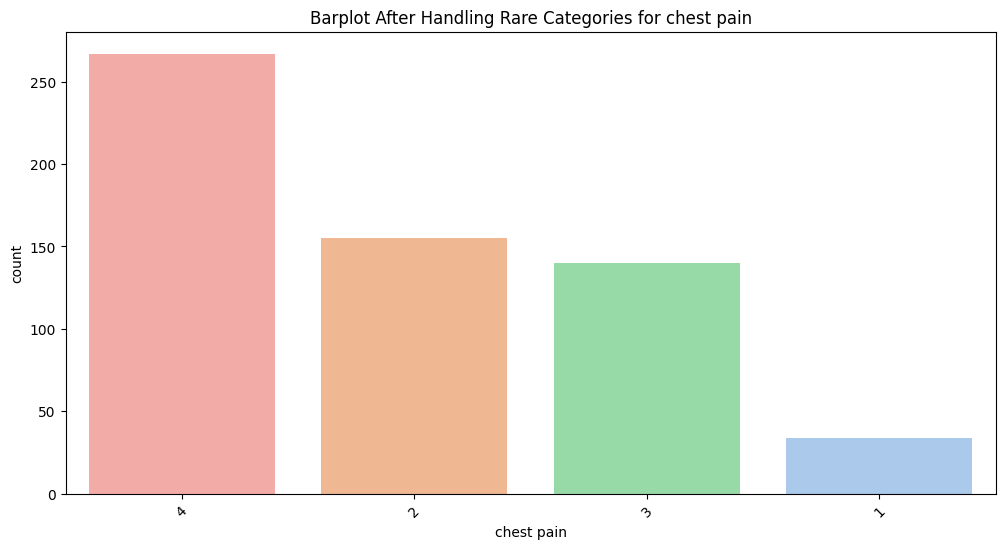


Analyzing Column: blood pressure
Type: Numerical

Analyzing Distribution for: blood pressure
Shapiro-Wilk Test: Statistic=0.9599, p-value=0.0000
The distribution of blood pressure appears to be Non-Normal.
Using IQR to Detect Outliers...
Number of Outliers Detected: 17
Handling Outliers by Clipping...


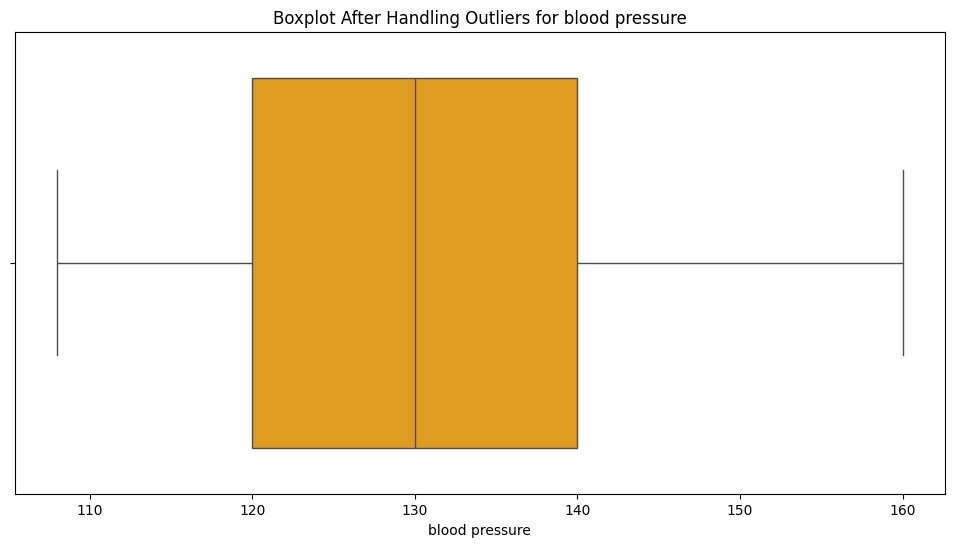


Analyzing Column: cholestoral 
Type: Numerical

Analyzing Distribution for: cholestoral 
Shapiro-Wilk Test: Statistic=0.9199, p-value=0.0000
The distribution of cholestoral  appears to be Non-Normal.
Using IQR to Detect Outliers...
Number of Outliers Detected: 19
Handling Outliers by Clipping...


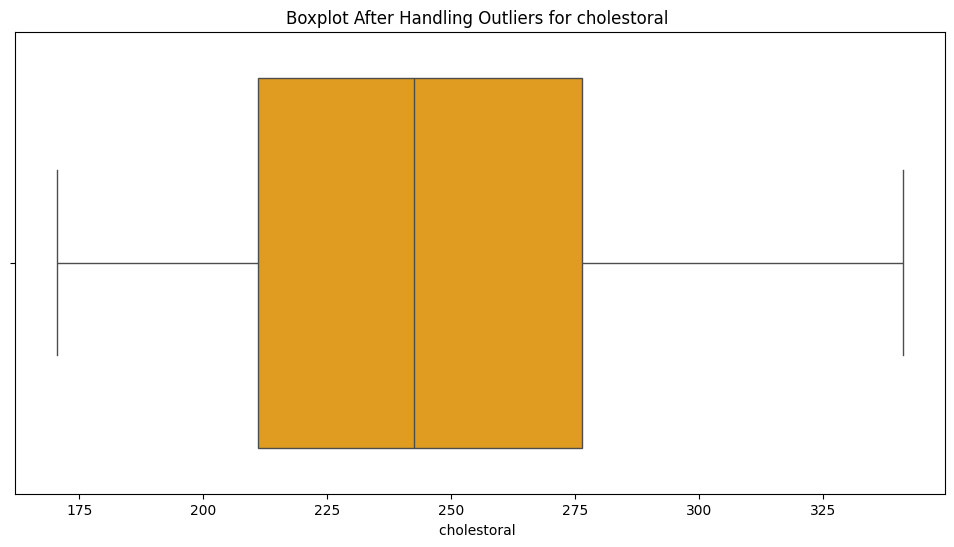


Analyzing Column: blood sugar
Type: Categorical
Value Counts:
blood sugar
0.0    531
1.0     65
Name: count, dtype: int64
Rare Categories: []


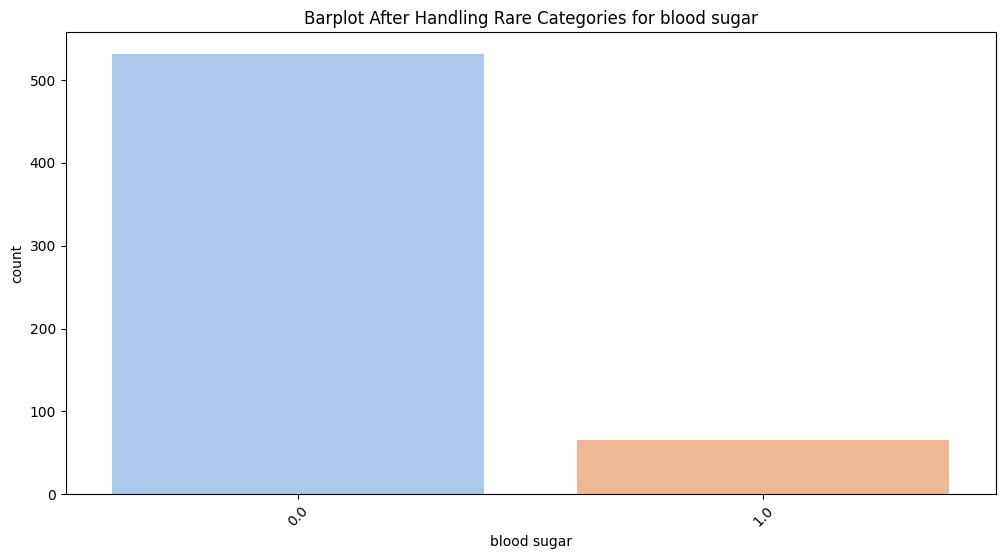


Analyzing Column: electrocardiographic 
Type: Categorical
Value Counts:
electrocardiographic 
0.0    386
2.0    154
1.0     56
Name: count, dtype: int64
Rare Categories: []


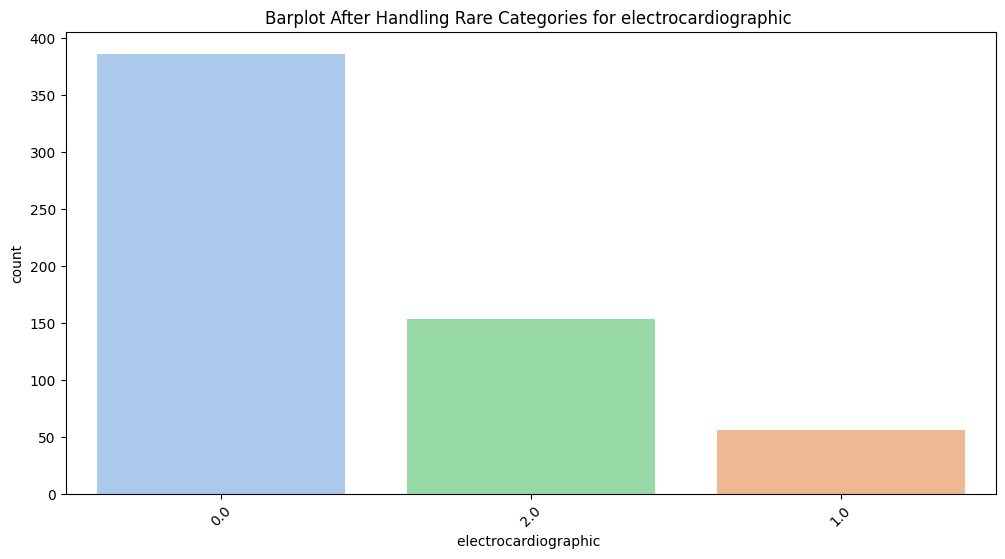


Analyzing Column: heart rate
Type: Numerical

Analyzing Distribution for: heart rate
Shapiro-Wilk Test: Statistic=0.9862, p-value=0.0000
The distribution of heart rate appears to be Non-Normal.
Using IQR to Detect Outliers...
Number of Outliers Detected: 1
Handling Outliers by Clipping...


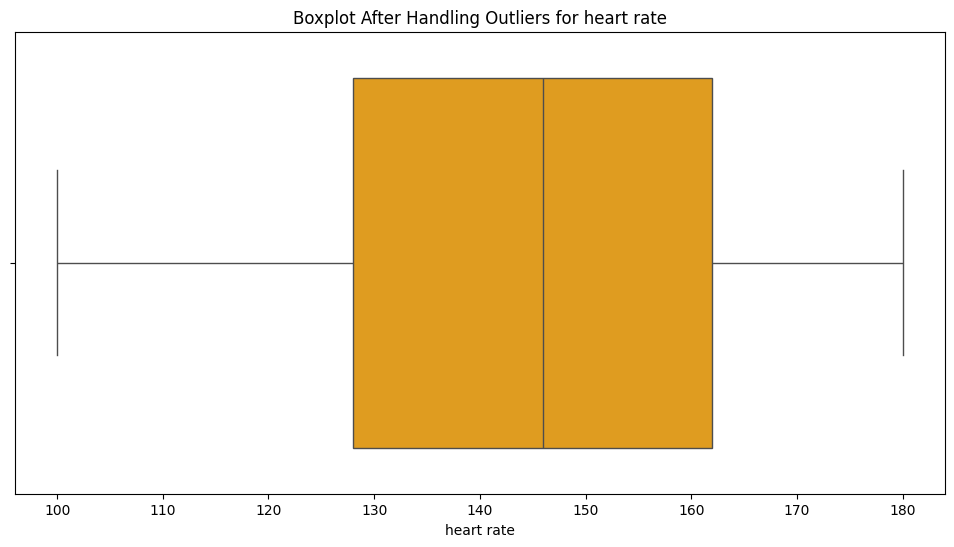


Analyzing Column: exercise induced
Type: Categorical
Value Counts:
exercise induced
0.0    408
1.0    188
Name: count, dtype: int64
Rare Categories: []


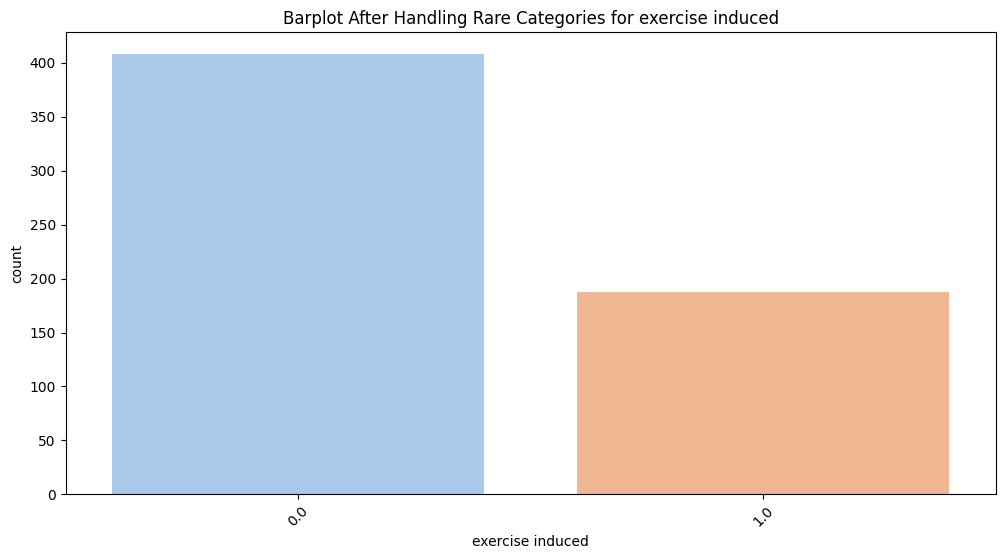


Analyzing Column: depression 
Type: Numerical

Analyzing Distribution for: depression 
Shapiro-Wilk Test: Statistic=0.7803, p-value=0.0000
The distribution of depression  appears to be Non-Normal.
Using IQR to Detect Outliers...
Number of Outliers Detected: 11
Handling Outliers by Clipping...


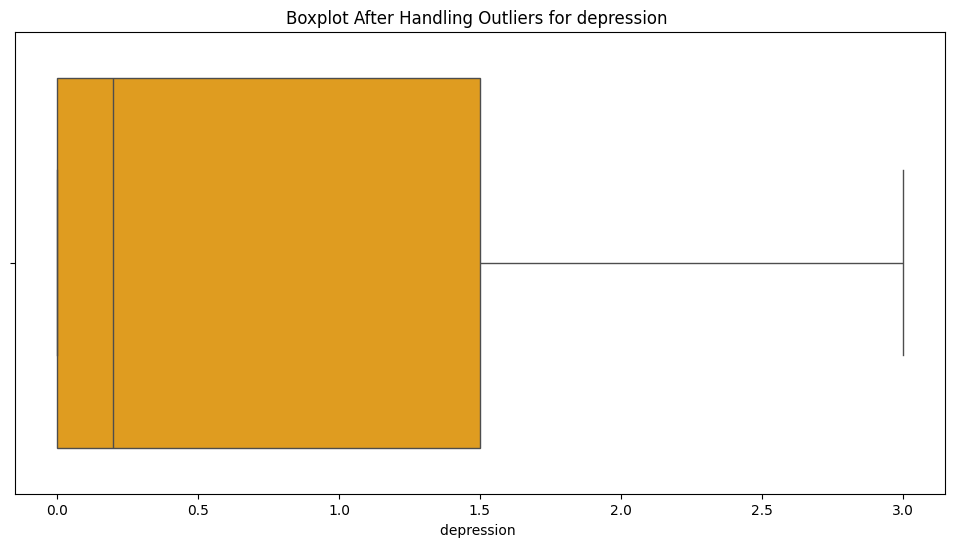


Analyzing Column: slope
Type: Categorical
Value Counts:
slope
2.0    420
1.0    154
3.0     22
Name: count, dtype: int64
Rare Categories: [3.0]
Handling Rare Categories by Combining into 'Other'


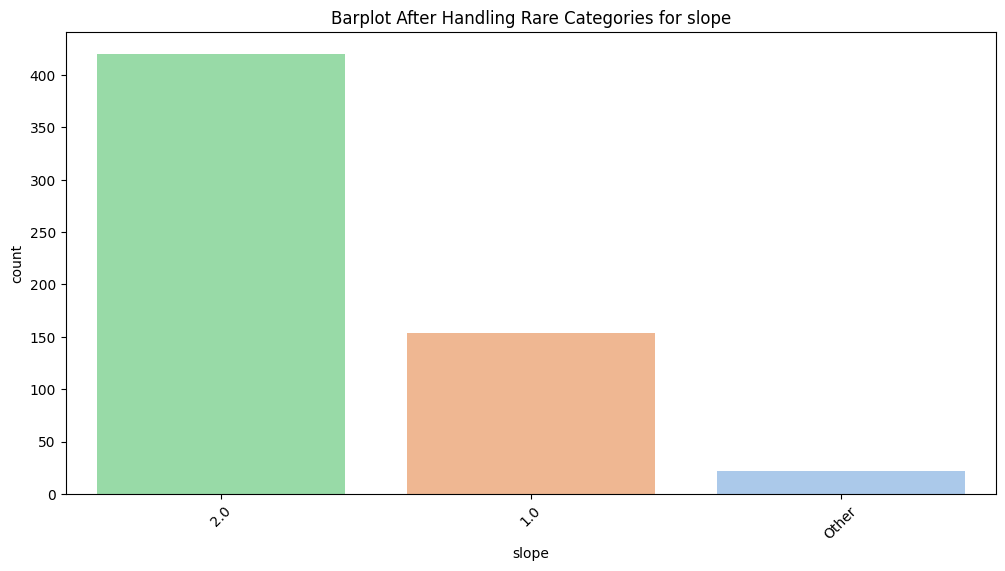


Analyzing Column: ca
Type: Categorical
Value Counts:
ca
0.0    472
1.0     65
2.0     38
3.0     20
9.0      1
Name: count, dtype: int64
Rare Categories: [3.0, 9.0]
Handling Rare Categories by Combining into 'Other'


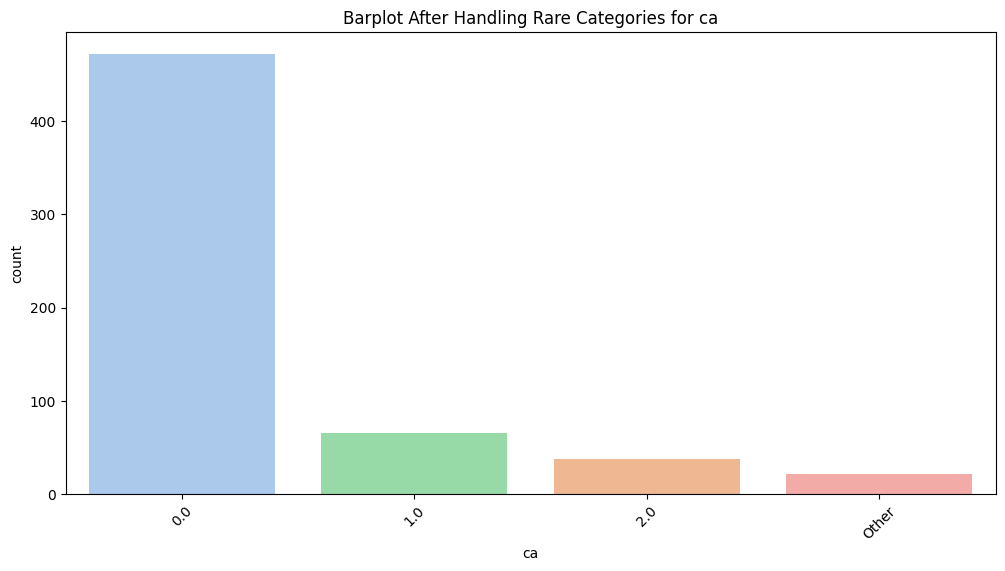


Analyzing Column: thal
Type: Categorical
Value Counts:
thal
3.0    440
7.0    128
6.0     28
Name: count, dtype: int64
Rare Categories: [6.0]
Handling Rare Categories by Combining into 'Other'


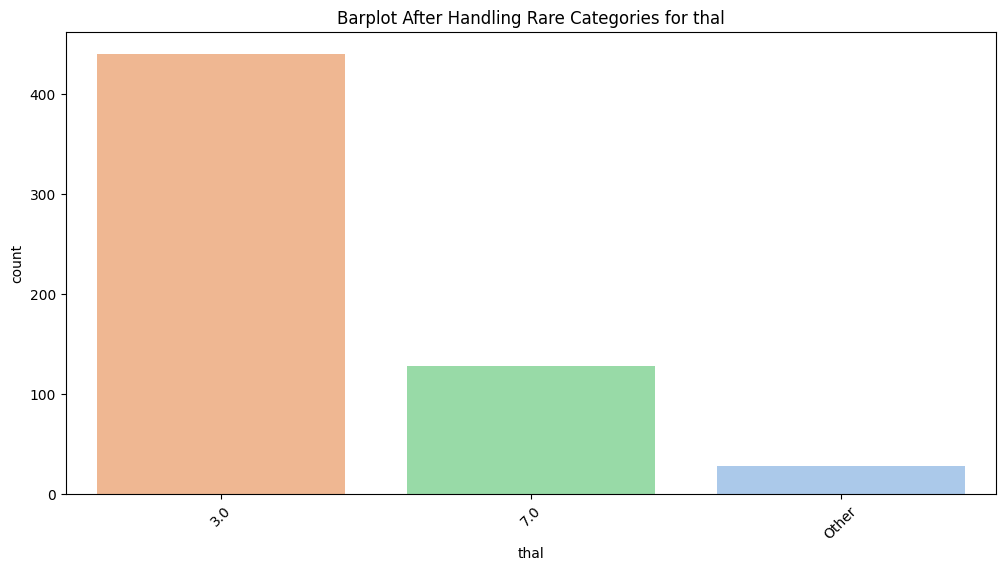


Analyzing Column: c
Type: Categorical
Value Counts:
c
0    351
1    245
Name: count, dtype: int64
Rare Categories: []


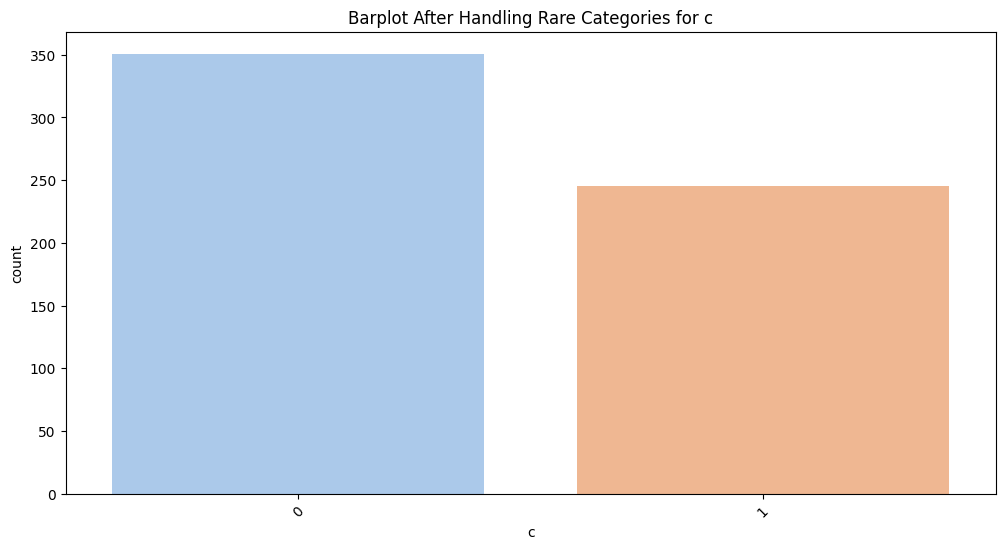


Step: Statistical Analysis After Cleaning

Step: Statistical Analysis and Visualization of Fields
Analyzing Field: Age (age in year)
Numerical Field
count    596.000000
mean      51.186242
std        9.081547
min       28.000000
25%       44.000000
50%       52.000000
75%       58.000000
max       77.000000
Name: Age (age in year), dtype: float64


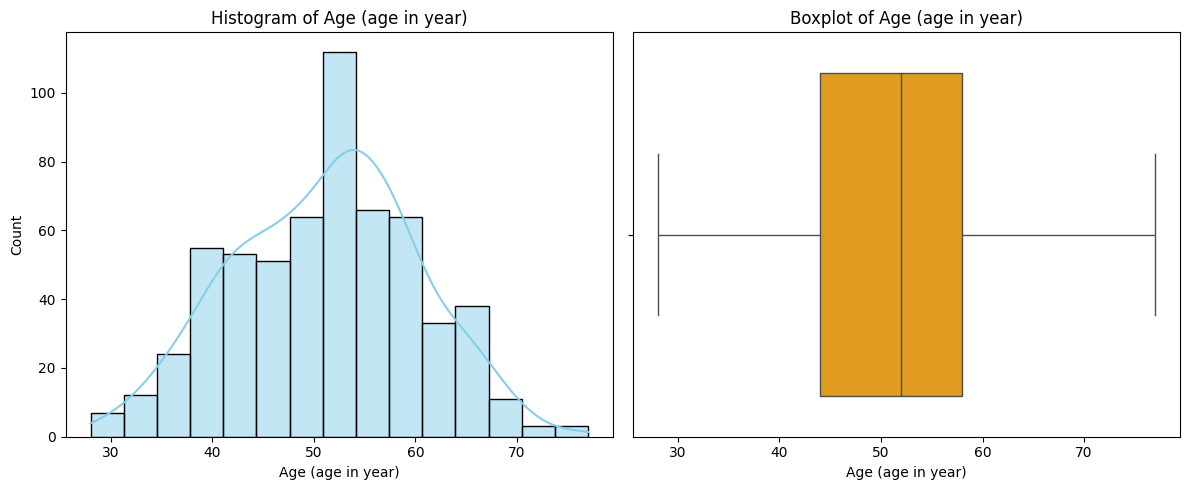

Analyzing Field: sex
Categorical Field
sex
1    419
0    177
Name: count, dtype: int64


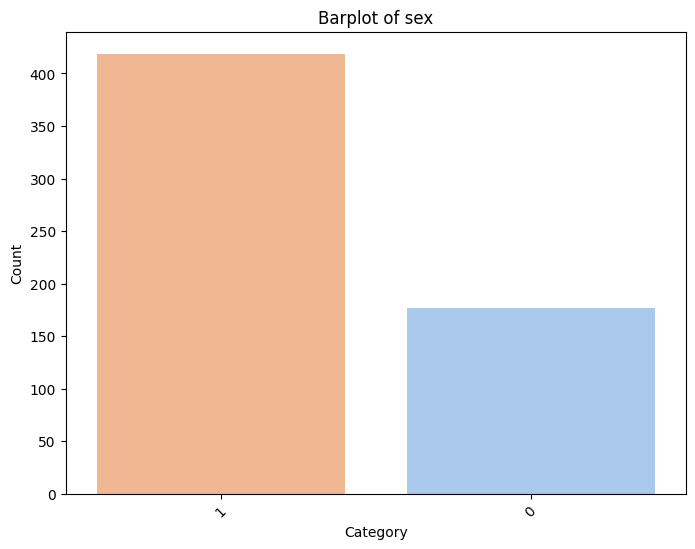

Analyzing Field: chest pain
Categorical Field
chest pain
4    267
2    155
3    140
1     34
Name: count, dtype: int64


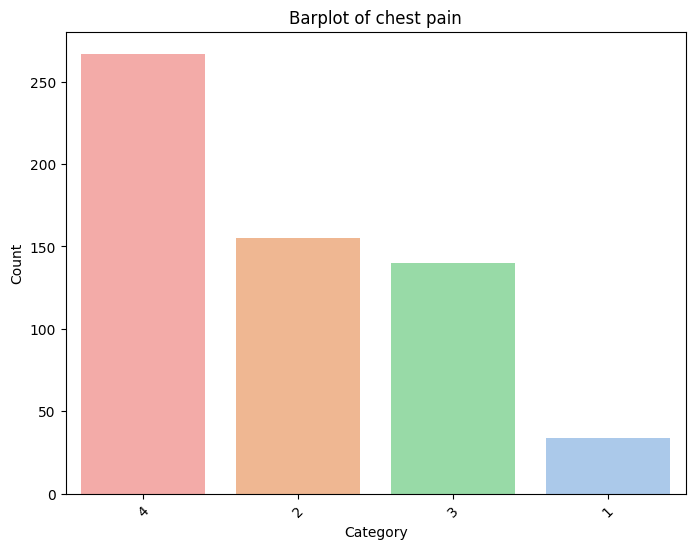

Analyzing Field: blood pressure
Numerical Field
count    596.000000
mean     131.642617
std       15.133406
min      108.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      160.000000
Name: blood pressure, dtype: float64


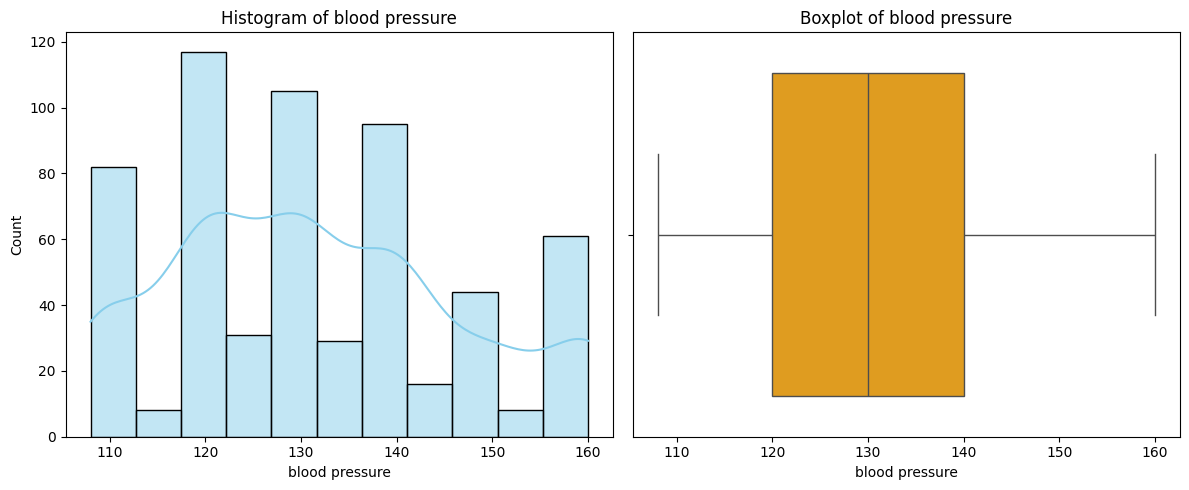

Analyzing Field: cholestoral 
Numerical Field
count    596.000000
mean     246.179530
std       46.405498
min      170.500000
25%      211.000000
50%      242.500000
75%      276.250000
max      341.000000
Name: cholestoral , dtype: float64


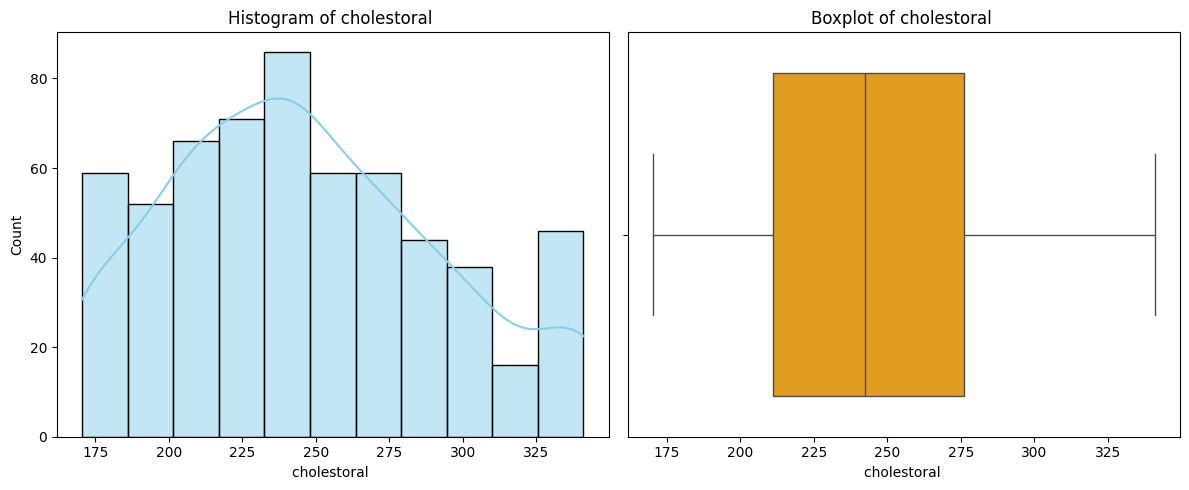

Analyzing Field: blood sugar
Categorical Field
blood sugar
0.0    531
1.0     65
Name: count, dtype: int64


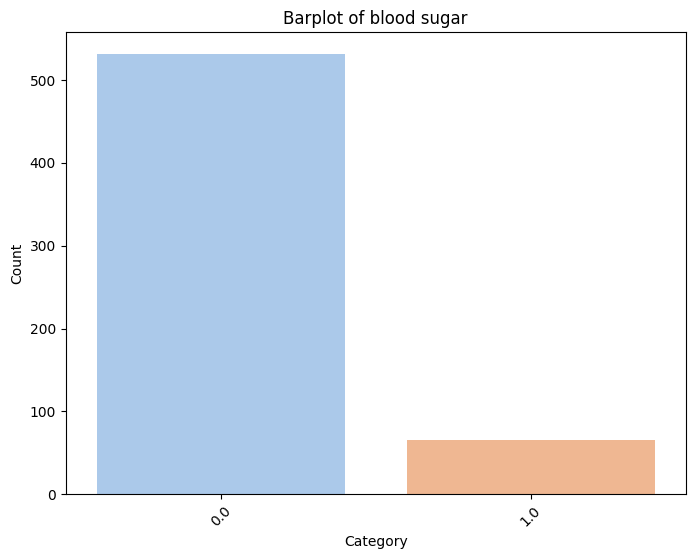

Analyzing Field: electrocardiographic 
Categorical Field
electrocardiographic 
0.0    386
2.0    154
1.0     56
Name: count, dtype: int64


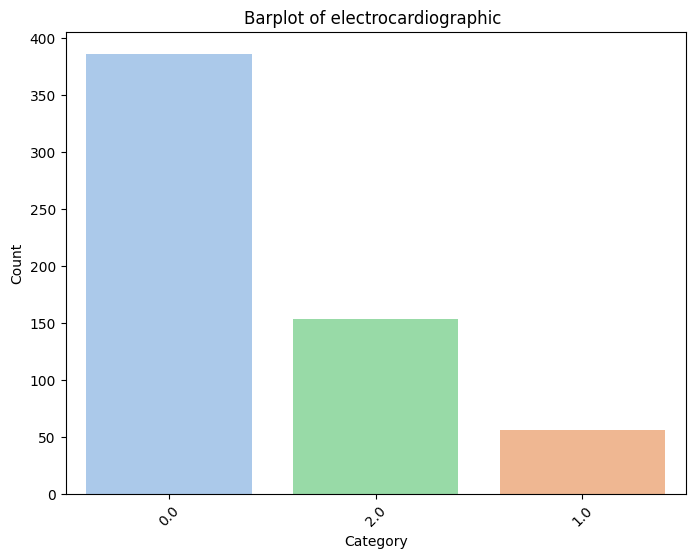

Analyzing Field: heart rate
Numerical Field
count    596.000000
mean     144.449664
std       22.653454
min      100.000000
25%      128.000000
50%      146.000000
75%      162.000000
max      180.000000
Name: heart rate, dtype: float64


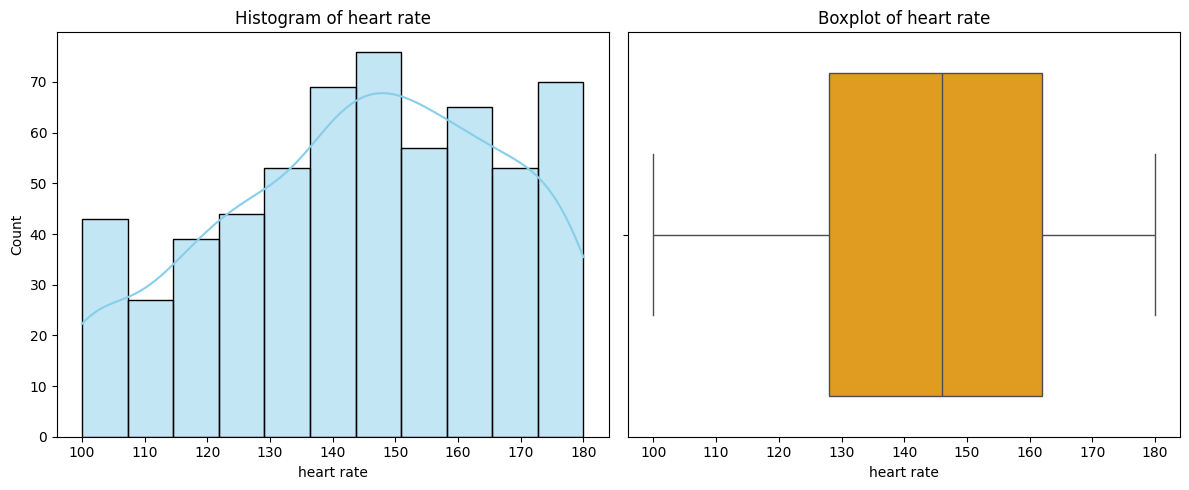

Analyzing Field: exercise induced
Categorical Field
exercise induced
0.0    408
1.0    188
Name: count, dtype: int64


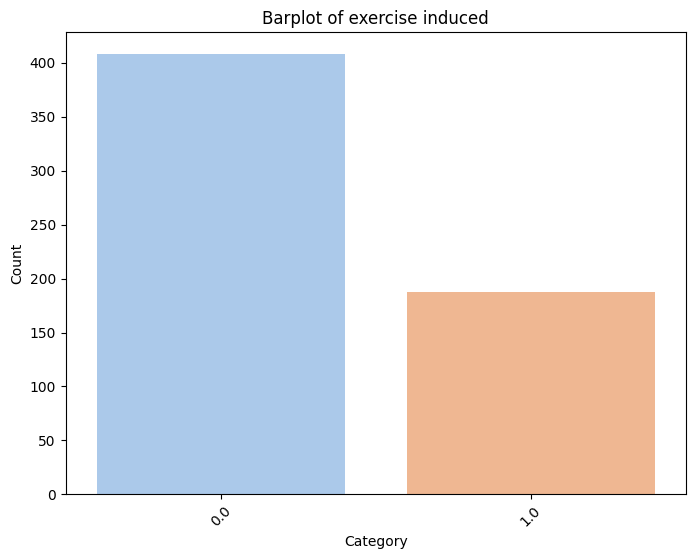

Analyzing Field: depression 
Numerical Field
count    596.000000
mean       0.782383
std        0.964866
min        0.000000
25%        0.000000
50%        0.200000
75%        1.500000
max        3.000000
Name: depression , dtype: float64


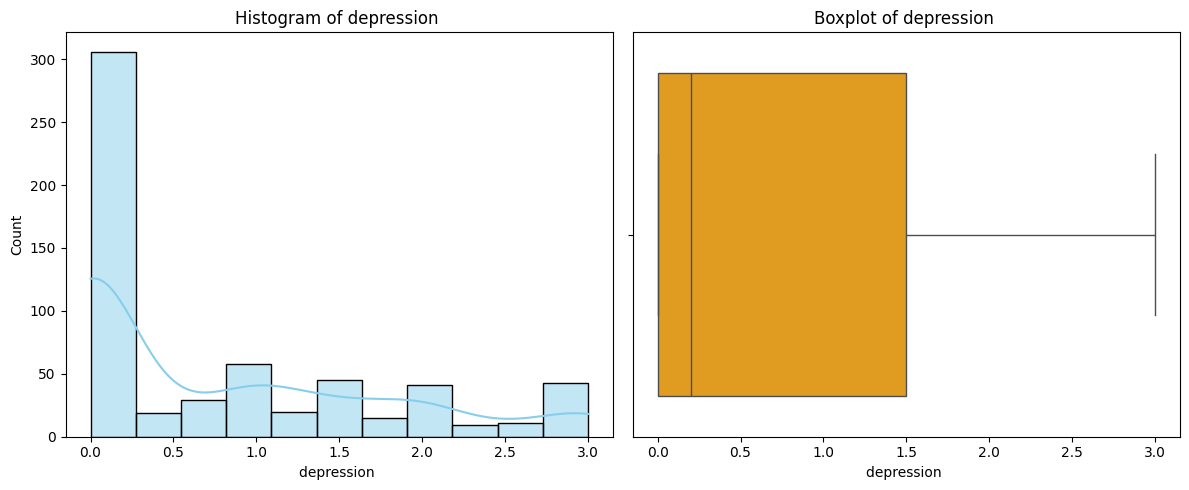

Analyzing Field: slope
Categorical Field
slope
2.0      420
1.0      154
Other     22
Name: count, dtype: int64


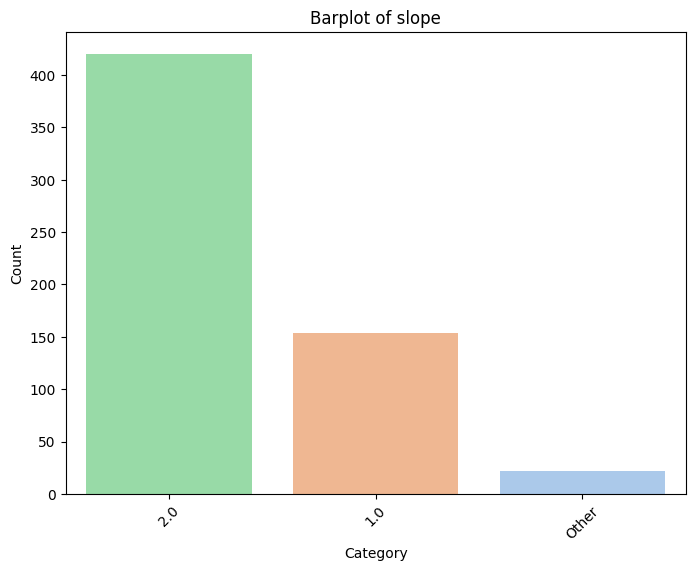

Analyzing Field: ca
Categorical Field
ca
0.0      472
1.0       65
2.0       38
Other     21
Name: count, dtype: int64


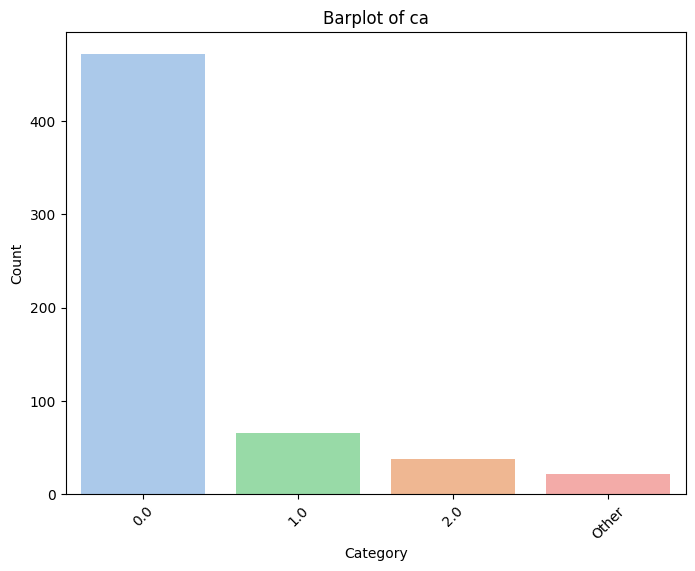

Analyzing Field: thal
Categorical Field
thal
3.0      440
7.0      128
Other     28
Name: count, dtype: int64


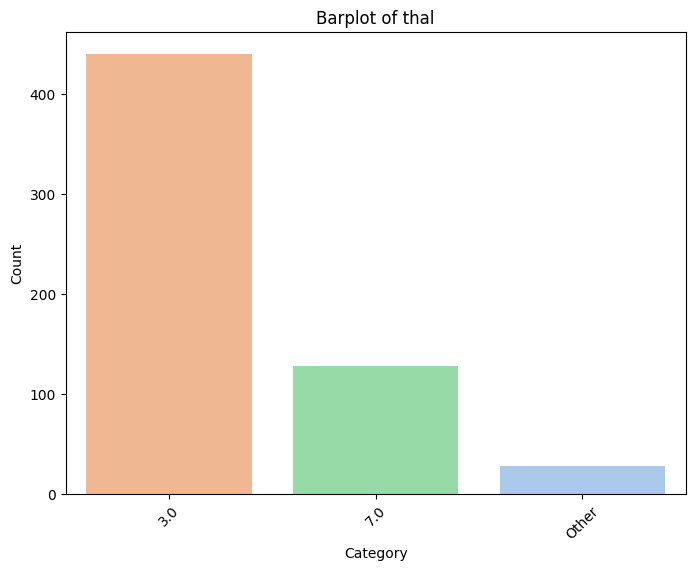

Analyzing Field: c
Categorical Field
c
0    351
1    245
Name: count, dtype: int64


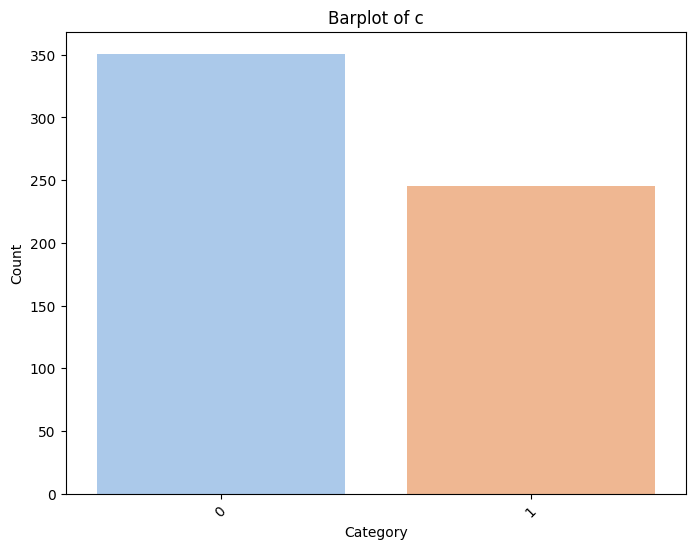


Step: Analyzing Data After Cleaning

Data Analysis - After Cleaning
Rows: 596
Columns: 14
Missing Values: 0
Duplicate Rows: 0
Categorical Features: ['sex', 'chest pain', 'blood sugar', 'electrocardiographic ', 'exercise induced', 'slope', 'ca', 'thal', 'c']
Numerical Features: ['cholestoral ', 'blood pressure', 'heart rate', 'depression ', 'Age (age in year)']

Comparison of Data Statistics Before and After Cleaning:
           Metric  Before Cleaning  After Cleaning
0            Rows              597             596
1         Columns               14              14
2  Missing Values              787               0
3  Duplicate Rows                1               0


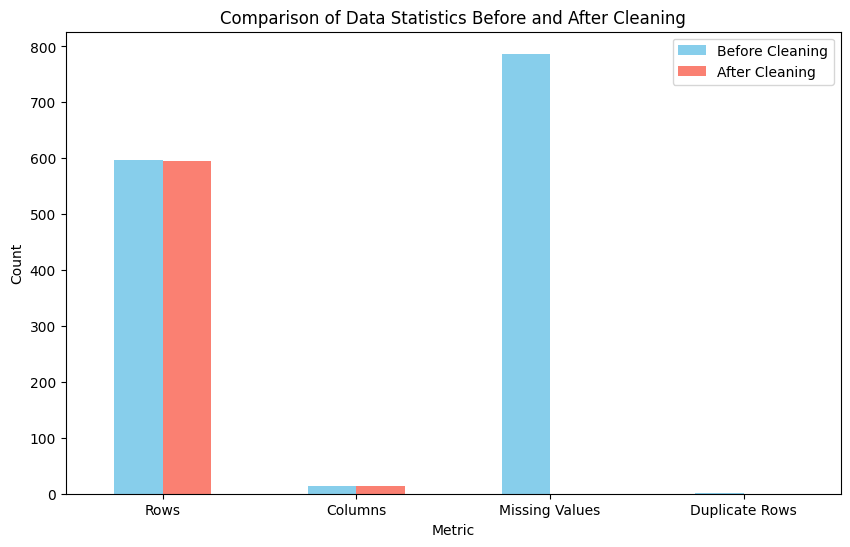


Step: Save new dataset After Cleaning

 Cleaned dataset saved.


In [ ]:
file_path = '/content/drive/MyDrive/Tjali_Python Project'
data = read_dataset(file_path+'/Heart data.csv')
crisp_data_cleaning(data, 'cleaned_Heart_data.csv')

Execute CRISP-DM Preparing process

In [ ]:
cleaned_data = read_dataset(file_path+'/cleaned_Heart_data.csv')
X_train, X_test, y_train, y_test = crisp_data_preparing(cleaned_data)

Step: Detecting categorical and numerical columns.

Step: Splitting Data.

Step: Splitting Data into Training and Testing Sets

Step: Handling Imbalance.

No significant class imbalance detected.

Step: Transforming X_train, X_test.

Transformed  X_train, X_test.

Step: X_train , X_test , y_train, y_test are Prepared for modeling.

The training data is processed:
     Age (age in year)  sex  chest pain  blood pressure  cholestoral   \
46            0.326531    1           2        0.615385      0.378299   
566           0.489796    1           3        0.423077      0.747801   
39            0.755102    0           2        1.000000      1.000000   
326           0.551020    0           1        0.269231      0.876833   
3             0.571429    1           1        0.230769      0.384164   

     blood sugar  electrocardiographic   heart rate  exercise induced  \
46             0                      2      1.0000                 0   
566            0                      0      0.12

Execute CRISP-DM Modeling, Evaluating and Optimation process


Training Logistic Regression model...
Evaluating Logistic Regression...
Accuracy: 0.8167
Precision: 0.8140
Recall: 0.7143
F1-Score: 0.7609
AUC-ROC: 0.8890

Confusion Matrix:
[[63  8]
 [14 35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        71
           1       0.81      0.71      0.76        49

    accuracy                           0.82       120
   macro avg       0.82      0.80      0.81       120
weighted avg       0.82      0.82      0.81       120

Logistic Regression Test Accuracy: 0.8166666666666667

Training Random Forest model...
Evaluating Random Forest...
Accuracy: 0.8417
Precision: 0.8571
Recall: 0.7347
F1-Score: 0.7912
AUC-ROC: 0.8931

Confusion Matrix:
[[65  6]
 [13 36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        71
           1       0.86      0.73      0.79        49

    accuracy                     

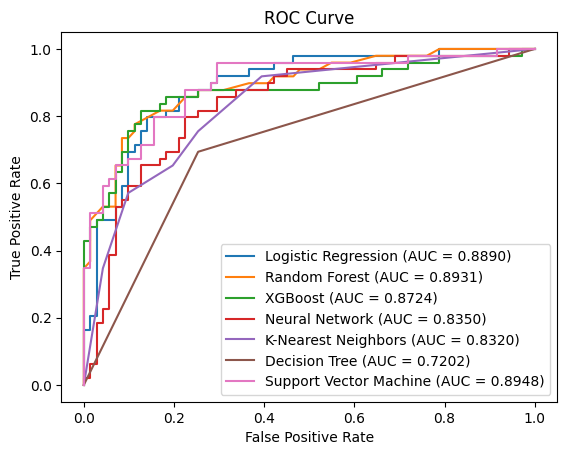


Summary of Results:
                              Accuracy  Precision    Recall  F1-Score  \
Logistic Regression           0.816667   0.813953  0.714286  0.760870   
Random Forest                 0.841667   0.857143  0.734694  0.791209   
XGBoost                       0.833333   0.808511  0.775510  0.791667   
Neural Network                0.758333   0.763158  0.591837  0.666667   
K-Nearest Neighbors (KNN)     0.741667   0.695652  0.653061  0.673684   
Decision Tree                 0.725000   0.653846  0.693878  0.673267   
Support Vector Machine (SVM)  0.800000   0.790698  0.693878  0.739130   

                               AUC-ROC  
Logistic Regression           0.889049  
Random Forest                 0.893073  
XGBoost                       0.872377  
Neural Network                0.835010  
K-Nearest Neighbors (KNN)     0.831992  
Decision Tree                 0.720178  
Support Vector Machine (SVM)  0.894797  


In [ ]:
results = []
results = train_and_evaluate(X_train, X_test, y_train, y_test)

# Display summary of results
Display_results(results)


Training Logistic Regression model...
Evaluating Logistic Regression...
Accuracy: 0.8508
Precision: 0.8571
Recall: 0.7653
F1-Score: 0.8086
AUC-ROC: 0.8842

Confusion Matrix:
[[255  25]
 [ 46 150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       280
           1       0.86      0.77      0.81       196

    accuracy                           0.85       476
   macro avg       0.85      0.84      0.84       476
weighted avg       0.85      0.85      0.85       476

Logistic Regression Train Accuracy: 0.8508403361344538
Logistic Regression Test Accuracy: 0.8

Training Random Forest model...
Evaluating Random Forest...
Accuracy: 0.8403
Precision: 0.8226
Recall: 0.7806
F1-Score: 0.8010
AUC-ROC: 0.8909

Confusion Matrix:
[[247  33]
 [ 43 153]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       280
           1       0.82      0.78      0

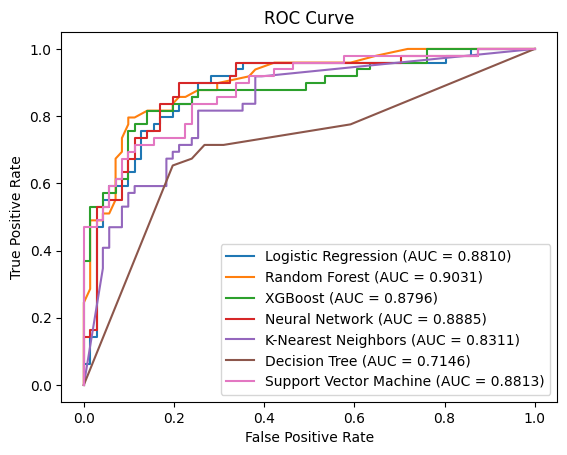


Summary of Results:
                              Accuracy  Precision    Recall  F1-Score  \
Logistic Regression           0.850840   0.857143  0.765306  0.808625   
Random Forest                 0.840336   0.822581  0.780612  0.801047   
XGBoost                       0.823529   0.807692  0.750000  0.777778   
Neural Network                0.852941   0.857955  0.770408  0.811828   
K-Nearest Neighbors (KNN)     0.823529   0.814607  0.739796  0.775401   
Decision Tree                 0.760504   0.711340  0.704082  0.707692   
Support Vector Machine (SVM)  0.829832   0.814208  0.760204  0.786280   

                               AUC-ROC  
Logistic Regression           0.884220  
Random Forest                 0.890944  
XGBoost                       0.886534  
Neural Network                0.893203  
K-Nearest Neighbors (KNN)     0.885405  
Decision Tree                 0.744178  
Support Vector Machine (SVM)  0.904264  


In [ ]:
results = []
results = train_and_cross_validate(X_train, X_test, y_train, y_test)

# Display summary of results
Display_results(results)


Training Logistic Regression model...
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Evaluating OptimizedLogistic Regression...
Accuracy: 0.8000
Precision: 0.8049
Recall: 0.6735
F1-Score: 0.7333
AUC-ROC: 0.8810

Confusion Matrix:
[[63  8]
 [16 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        71
           1       0.80      0.67      0.73        49

    accuracy                           0.80       120
   macro avg       0.80      0.78      0.79       120
weighted avg       0.80      0.80      0.80       120

Logistic Regression Test Accuracy: 0.8

Training Random Forest model...
Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}
Evaluating OptimizedRandom Forest...
Accuracy: 0.8417
Precision: 0.8571
Recall: 0.7347
F1-Score: 0.7912
AUC-ROC: 0.9031

Confusion Matrix:
[[65  6]
 [13 36]]
Classification Report:
              precision    recall  f1-score 

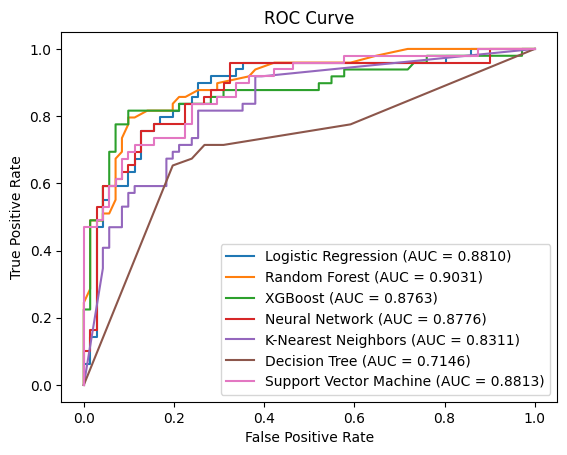


Summary of Results:
                              Accuracy  Precision    Recall  F1-Score  \
Logistic Regression           0.800000   0.804878  0.673469  0.733333   
Random Forest                 0.841667   0.857143  0.734694  0.791209   
XGBoost                       0.866667   0.883721  0.775510  0.826087   
Neural Network                0.791667   0.800000  0.653061  0.719101   
K-Nearest Neighbors (KNN)     0.758333   0.708333  0.693878  0.701031   
Decision Tree                 0.725000   0.660000  0.673469  0.666667   
Support Vector Machine (SVM)  0.808333   0.809524  0.693878  0.747253   

                               AUC-ROC  
Logistic Regression           0.881000  
Random Forest                 0.903133  
XGBoost                       0.876258  
Neural Network                0.877551  
K-Nearest Neighbors (KNN)     0.831130  
Decision Tree                 0.714573  
Support Vector Machine (SVM)  0.881288  


In [ ]:
results = []
results = optimize_models(X_train, y_train, X_test, y_test)

# Display summary of results
Display_results(results)


Training Logistic Regression model...
Evaluating Logistic Regression...
Accuracy: 0.8508
Precision: 0.8571
Recall: 0.7653
F1-Score: 0.8086
AUC-ROC: 0.8842

Confusion Matrix:
[[255  25]
 [ 46 150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       280
           1       0.86      0.77      0.81       196

    accuracy                           0.85       476
   macro avg       0.85      0.84      0.84       476
weighted avg       0.85      0.85      0.85       476

Logistic Regression Train Accuracy: 0.8508403361344538
Logistic Regression Test Accuracy: 0.8

Training Random Forest model...
Evaluating Random Forest...
Accuracy: 0.8403
Precision: 0.8226
Recall: 0.7806
F1-Score: 0.8010
AUC-ROC: 0.8909

Confusion Matrix:
[[247  33]
 [ 43 153]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       280
           1       0.82      0.78      0

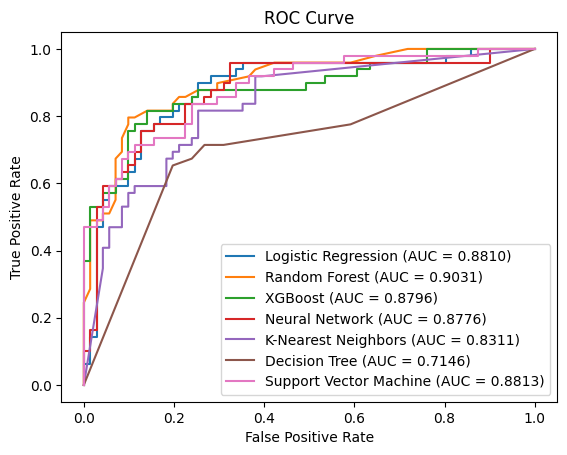


Summary of Results:
                              Accuracy  Precision    Recall  F1-Score  \
Logistic Regression           0.850840   0.857143  0.765306  0.808625   
Random Forest                 0.840336   0.822581  0.780612  0.801047   
XGBoost                       0.823529   0.807692  0.750000  0.777778   
Neural Network                0.857143   0.863636  0.775510  0.817204   
K-Nearest Neighbors (KNN)     0.823529   0.814607  0.739796  0.775401   
Decision Tree                 0.760504   0.711340  0.704082  0.707692   
Support Vector Machine (SVM)  0.829832   0.814208  0.760204  0.786280   

                               AUC-ROC  
Logistic Regression           0.884220  
Random Forest                 0.890944  
XGBoost                       0.886534  
Neural Network                0.886079  
K-Nearest Neighbors (KNN)     0.885405  
Decision Tree                 0.744178  
Support Vector Machine (SVM)  0.904264  


In [ ]:
results = []
results = train_and_cross_validate_AfterOpt(X_train, X_test, y_train, y_test)

# Display summary of results
Display_results(results)